# Problem:
> Bir oda içerisinde kişi olup olmadığını tespit etmek.

## Beklentiler:
- Eğitim sonuçları ve analiz kısımlarında gözlemlerin paylaşılması 
- Preprocessing adımlarının bilinçli bir şekilde uygulanması
- Train ile eğitip, dev ile değerlendirip son olarak model başarısını test veri seti ile test edilmesi 


Sıcaklık, nem ve CO2 seviyesi gibi çevresel gözlemleri kullanarak oda içerisinde kişi olup olmadığını tespit etmek için modeller geliştirdim. Bu model tahminleri Isıtma, Havalandırma ve İklimlendirme (Heating, ventilation and air conditioning/HVAC) sektöründe kullanılan  Akıllı Oda Algılama Sistemleri gibi projelerde yardımcı olabilir. Örneğin, ortam hakkında bilgi almak için termostat gibi sensörler kullanıyoruz ve bu bilgilerle sistemimiz odayı ısıtıp ısıtmamaya karar verebilir. 

# 1. Import Libraries
- numpy, pandas, scikit-learn, matplotlib gibi kütüphaneler import edilmesi 

In [1]:
import sys
print(sys.version)

3.7.16 (default, Jan 17 2023, 16:06:28) [MSC v.1916 64 bit (AMD64)]


In [2]:
#!pip install missingno

In [3]:
# import subprocess

# libraries = ['mxnet', 'pandas', 'numpy', 'seaborn', 'plotly', 'scikit-learn', 'xgboost', 'catboost', 'lightgbm', 'matplotlib', 'keras', 'tensorflow', 'missingno', 'imbalanced-learn']

# for library in libraries:
#     subprocess.call(['pip', 'install', library])

In [4]:
import numpy as np
import pandas as pd 
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, iplot, plot
init_notebook_mode(connected=True)
import plotly.express as px
import plotly.graph_objects as go

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

In [6]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.metrics import classification_report

In [7]:
#pip install keras,tensorflow
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.regularizers import l2, l1
from keras.metrics import BinaryAccuracy

In [8]:
import missingno as msno

# 2. Load Datasets
- veri setlerinin ilgili dosyalardan okunması 

In [9]:
train = pd.read_csv("C:/Users/skumsar/Desktop/q1/dataset/train.csv")
dev = pd.read_csv("C:/Users/skumsar/Desktop/q1/dataset/dev.csv")
test = pd.read_csv("C:/Users/skumsar/Desktop/q1/dataset/test.csv")

Veri setimizi daha iyi anlamak ve gelecekteki analizlerimizi doğru bir şekilde yönlendirebilmek için, veri setinin detaylı bir incelemesini keşifsel veri analizi yöntemleri kullanarak inceledik. 

# 3. Exploratory Data Analysis
- Veri tipleri
- NaN, Kayıp değer
- Veri setindeki dağılımlar/dengesizlikler
- Tekrarlı değerler


<u><b>Not:</b> isterseniz daha fazla işlem de yapabilirsiniz (opsiyonel) </u>

### Veri tipleri

In [10]:
train.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
1,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
2,2015-02-04 17:53:00,NaN,27.2450,426.0,NaN,0.004779,1
3,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
4,2015-02-04 17:55:00,NaN,27.2000,426.0,NaN,0.004757,1


Tüm csv dosyalarının tarih, sıcaklık, nem, ışık, CO2, nem oranı ve doluluk olarak yedi sütunu vardır.

* Celsius cinsinden sıcaklık.
* Yüzde olarak Relative humidity(bağıl nem).
* Lux olarak ölçülen ışık.
* Carbon dioxide milyonda parça olarak ölçülür.
* Sıcaklık ve bağıl nemden elde edilen Humidity ratio(nem oranı), kilogram hava başına kilogram su buharı cinsinden ölçülür.
* Occupancy(Doluluk) dolu için 1 ve dolu değil için 0 olarak gösterilmiş.

Projemiz etiketli verileri seçerek model geliştirmek üzerine olduğu için burada bağımlı değişkenimizi anlamak önemlidir.

In [11]:
# Train Veri setindeki değişken ve gözlem sayısı
print("Gözlem sayısı : " ,len(train))
print("Değişken sayısı : ", len(train.columns))

Gözlem sayısı :  8143
Değişken sayısı :  7


Modelleri eğitmek için training olarak train(8143 örnek) veriseti, validation(doğrulama) olarak dev(2665 örnek) verisi ve test verisi olarak test(9752 örnek) kullanacağım.

In [12]:
print(train.info())
print(dev.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8143 entries, 0 to 8142
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           8143 non-null   object 
 1   Temperature    7763 non-null   float64
 2   Humidity       8143 non-null   float64
 3   Light          8143 non-null   float64
 4   CO2            7633 non-null   float64
 5   HumidityRatio  8143 non-null   float64
 6   Occupancy      8143 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 445.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2665 entries, 0 to 2664
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           2665 non-null   object 
 1   Temperature    2665 non-null   float64
 2   Humidity       2665 non-null   float64
 3   Light          2665 non-null   float64
 4   CO2            2665 non-null   float64
 5   HumidityRa

### NaN, Kayıp değer

In [13]:
#Train setindeki tüm değişkenlere bakış
train.describe(include = "all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
date,8143,8143,2015-02-04 17:51:00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Temperature,7763.0,NaN,NaN,NaN,20.576172,1.009679,19.0,19.7,20.39,21.29,23.18
Humidity,8143.0,NaN,NaN,NaN,25.731507,5.531211,16.745,20.2,26.2225,30.533333,39.1175
Light,8143.0,NaN,NaN,NaN,119.519375,194.755805,0.0,0.0,0.0,256.375,1546.333333
CO2,7633.0,NaN,NaN,NaN,604.032092,318.350143,412.75,439.0,452.5,621.5,2028.5
HumidityRatio,8143.0,NaN,NaN,NaN,0.003863,0.000852,0.002674,0.003078,0.003801,0.004352,0.006476
Occupancy,8143.0,NaN,NaN,NaN,0.21233,0.408982,0.0,0.0,0.0,0.0,1.0


In [14]:
# any= en az bir tane eksik değer varsa getir
# eksik değerleri bulundurur gözlemleri getiriyor.
train[train.isnull().any(axis = 1)]

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
2,2015-02-04 17:53:00,NaN,27.245,426.0,NaN,0.004779,1
4,2015-02-04 17:55:00,NaN,27.200,426.0,NaN,0.004757,1
5,2015-02-04 17:55:59,NaN,27.200,419.0,NaN,0.004757,1
6,2015-02-04 17:57:00,NaN,27.200,419.0,NaN,0.004757,1
7,2015-02-04 17:57:59,23.1,27.200,419.0,NaN,0.004757,1
...,...,...,...,...,...,...,...
1963,2015-02-06 02:34:00,NaN,19.290,0.0,NaN,0.002878,0
1967,2015-02-06 02:38:00,NaN,19.290,0.0,NaN,0.002887,0
1975,2015-02-06 02:45:59,NaN,19.290,0.0,NaN,0.002850,0
1982,2015-02-06 02:53:00,NaN,19.245,0.0,NaN,0.002843,0


In [15]:
# Her veri seti için kayıp değer sayılarını bul
train_missing_values = train.isnull().sum()
dev_missing_values = dev.isnull().sum()
test_missing_values = test.isnull().sum()

In [16]:
print("train_missing_values:", train_missing_values)
print("dev_missing_values:", dev_missing_values)
print("test_missing_values:", test_missing_values)

train_missing_values: date               0
Temperature      380
Humidity           0
Light              0
CO2              510
HumidityRatio      0
Occupancy          0
dtype: int64
dev_missing_values: date             0
Temperature      0
Humidity         0
Light            0
CO2              0
HumidityRatio    0
Occupancy        0
dtype: int64
test_missing_values: date             0
Temperature      0
Humidity         0
Light            0
CO2              0
HumidityRatio    0
Occupancy        0
dtype: int64


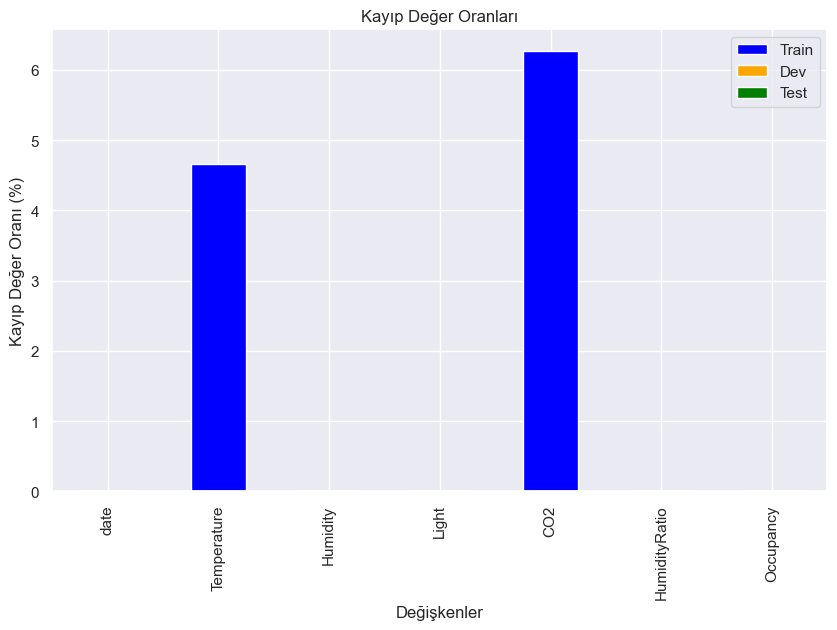

In [17]:
# Kayıp değer oranlarını hesapla
train_missing_percent = (train_missing_values / len(train)) * 100
dev_missing_percent = (dev_missing_values / len(dev)) * 100
test_missing_percent = (test_missing_values / len(test)) * 100

# Sonuçları görselleştir
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

train_missing_percent.plot(kind='bar', color='blue', label='Train')
dev_missing_percent.plot(kind='bar', color='orange', label='Dev')
test_missing_percent.plot(kind='bar', color='green', label='Test')

plt.title('Kayıp Değer Oranları')
plt.xlabel('Değişkenler')
plt.ylabel('Kayıp Değer Oranı (%)')
plt.legend()
plt.show()

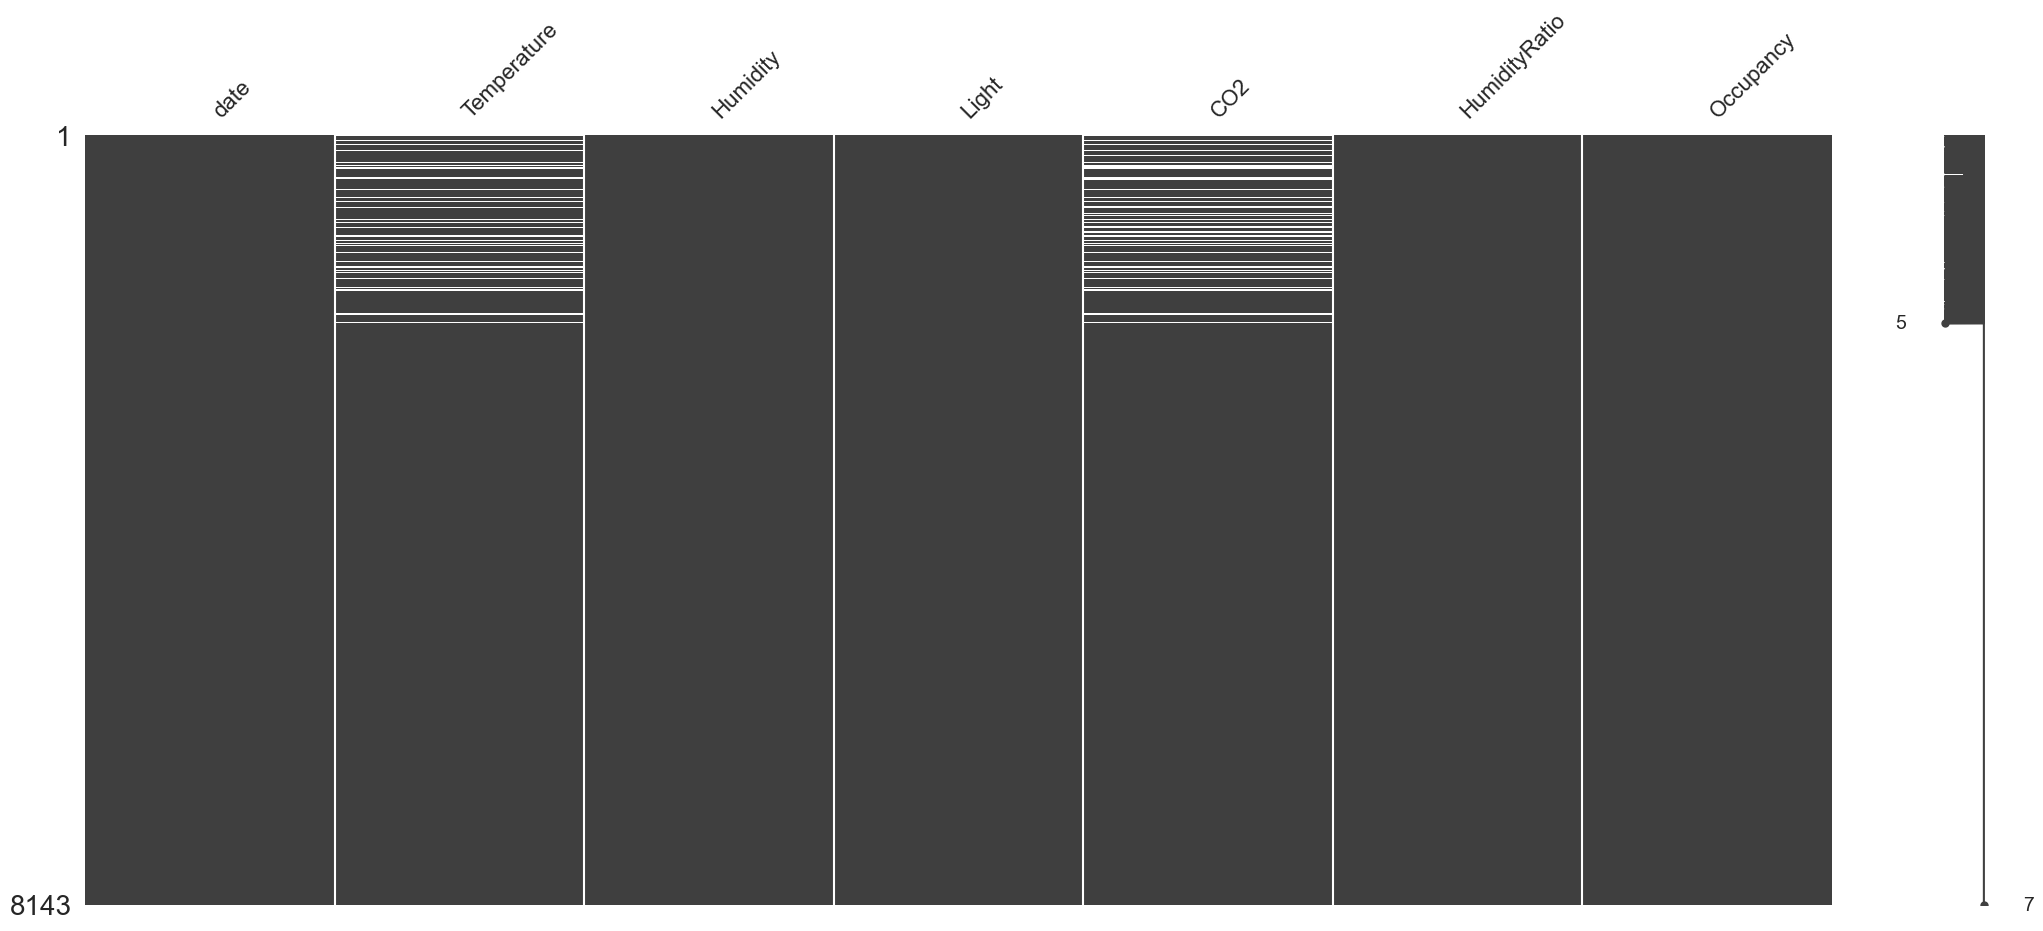

In [18]:
msno.matrix(train);
# eksik değerlerin rastsallığı yapısal bozukluğunu görme
# göz ile yakalanamayan eksiklikleri binlerce verideki gözlemi görmeyi sağlar

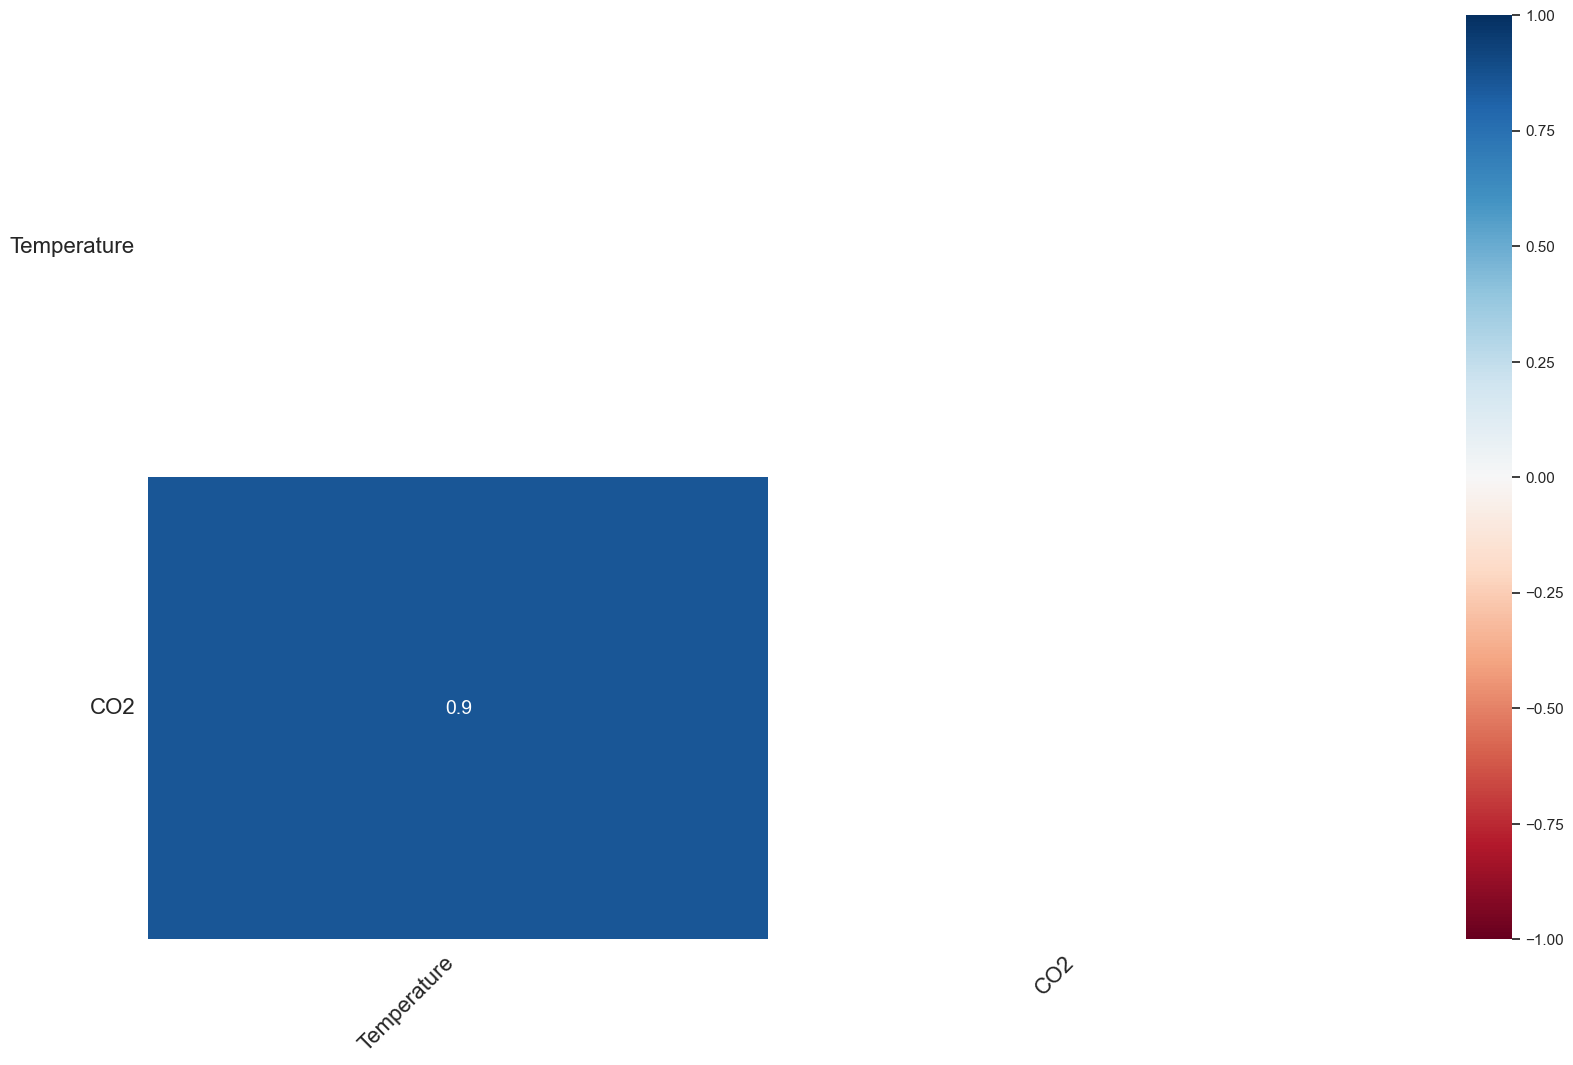

In [19]:
# Boşluklar arasında bir ilişki var mı?
# nullity correlation boşluk arasında bir bağ var mı?
msno.heatmap(train);
# Temperature ve CO2 değişkenleri arasında bir bağlılık vardır.
# heatmap çizdirdiğimiz de şiddetli bağlılık durumu (0.9) gözlenir.

### Veri setindeki dağılımlar/dengesizlikler

"date" ve "Occupancy" sütunlarını (axis=1) çıkartarak ve geri kalan sütunlar üzerinde yani bağımsız değişkenleriminiz istatistiksel özetini yazdıracak şekilde bir kutu grafiği çizilmesi sağladık.

       Temperature     Humidity        Light          CO2  HumidityRatio
count  7763.000000  8143.000000  8143.000000  7633.000000    8143.000000
mean     20.576172    25.731507   119.519375   604.032092       0.003863
std       1.009679     5.531211   194.755805   318.350143       0.000852
min      19.000000    16.745000     0.000000   412.750000       0.002674
25%      19.700000    20.200000     0.000000   439.000000       0.003078
50%      20.390000    26.222500     0.000000   452.500000       0.003801
75%      21.290000    30.533333   256.375000   621.500000       0.004352
max      23.180000    39.117500  1546.333333  2028.500000       0.006476


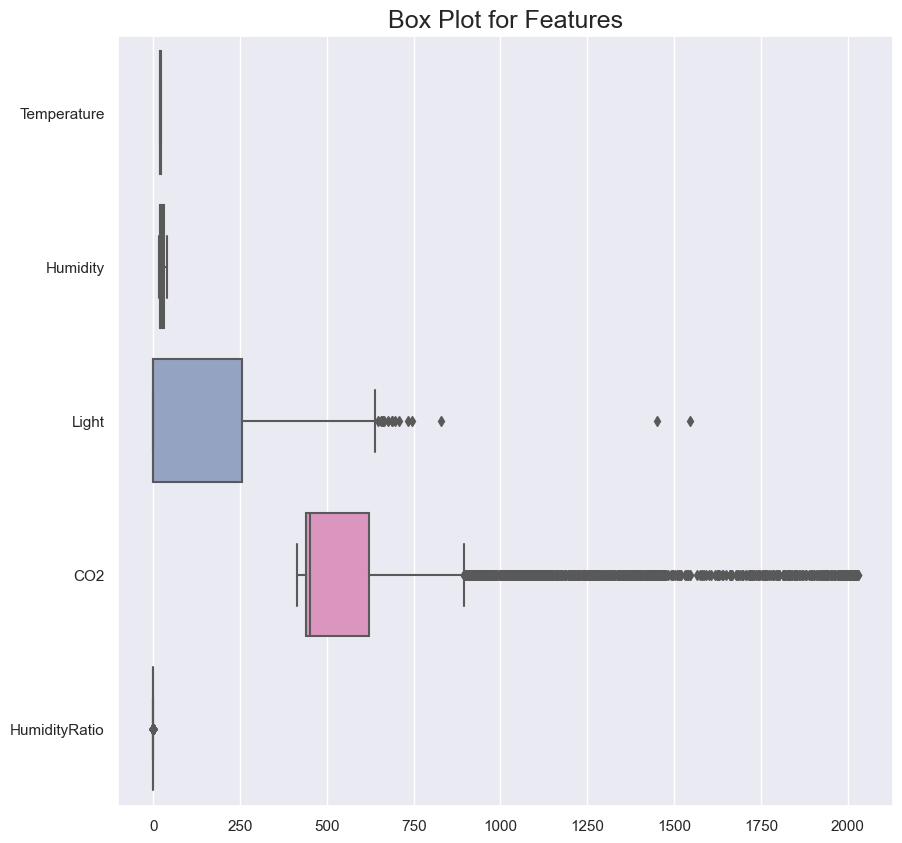

In [20]:
plt.figure(figsize=(10,10))
plt.title('Box Plot for Features', fontdict={'fontsize':18})
ax = sns.boxplot(data=train.drop(['date', 'Occupancy'],axis=1), orient="h", palette="Set2")
print(train.drop(['date', 'Occupancy'],axis=1).describe())

"train" veri setindeki özellikler arasındaki korelasyonu görselleştirdik. Her hücredeki değerler, özellikler arasındaki korelasyonun derecesini gösterir.

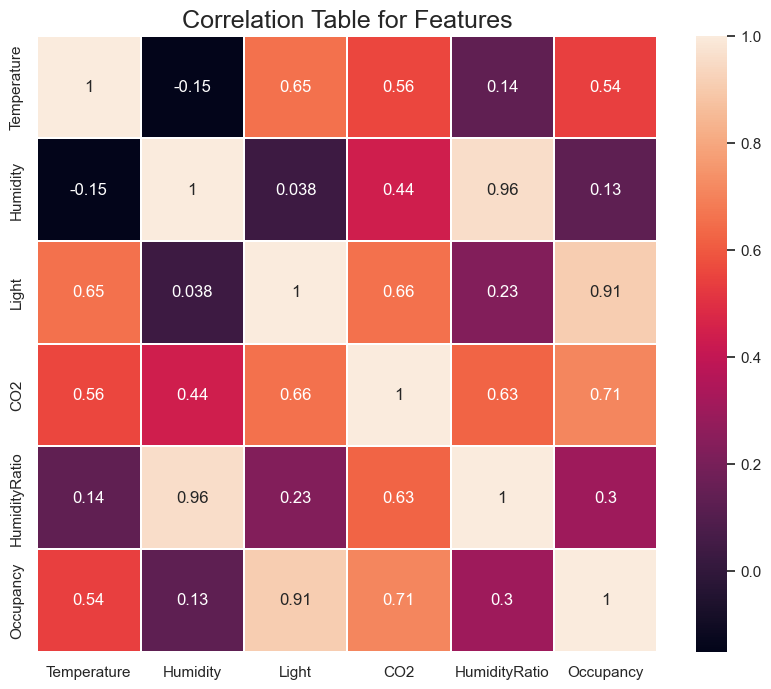

In [21]:
plt.figure(figsize=(10,8))
plt.title('Correlation Table for Features', fontdict={'fontsize':18})
ax = sns.heatmap(train.corr(), annot=True, linewidths=.2)

Doluluk ve diğerleri arasındaki korelasyonları görebiliriz. Beklediğimiz gibi, light değeri dolulukla diğerlerinden daha fazla ilişkilidir.

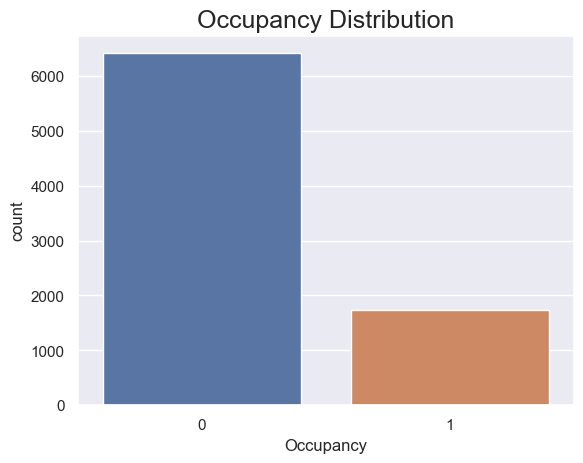

In [22]:
# Hedef değişkenin dağılımını yazdır
sns.set(style="darkgrid")
plt.title("Occupancy Distribution", fontdict={'fontsize':18})
ax = sns.countplot(x="Occupancy", data=train)

Verilerimiz dengesiz, bu nedenle tahminlerimizi güçlendirmek için özellikler arasında başka bir ilişki bulmamız gerekiyor.

In [23]:
train.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,7763.000000,8143.000000,8143.000000,7633.000000,8143.000000,8143.000000
mean,20.576172,25.731507,119.519375,604.032092,0.003863,0.212330
std,1.009679,5.531211,194.755805,318.350143,0.000852,0.408982
min,19.000000,16.745000,0.000000,412.750000,0.002674,0.000000
25%,19.700000,20.200000,0.000000,439.000000,0.003078,0.000000
50%,20.390000,26.222500,0.000000,452.500000,0.003801,0.000000
75%,21.290000,30.533333,256.375000,621.500000,0.004352,0.000000
max,23.180000,39.117500,1546.333333,2028.500000,0.006476,1.000000


Nem oranı(humidity_ratio) gibi düşük değerlere, ışık ve CO2 gibi yüksek değerlere sahip olduğumuz için, öğrenme sürecini basitleştirmek için verileri normalleştirmeliyiz.

### Tekrarlı değerler

In [24]:
# Veri setindeki tekrarlı değerleri bul
train_duplicate_count = train[train.duplicated()].sum()
dev_duplicate_count = dev[dev.duplicated()].sum()
test_duplicate_count = test[test.duplicated()].sum()

# Tekrarlı değerleri yazdır
print("Train Veri Setinde Tekrarlı Satır Sayısı:", train.duplicated().sum(), "\n", train_duplicate_count)
print("Dev Veri Setinde Tekrarlı Satır Sayısı:", dev.duplicated().sum(), "\n", dev_duplicate_count)
print("Test Veri Setinde Tekrarlı Satır Sayısı:", test.duplicated().sum(), "\n", test_duplicate_count)

Train Veri Setinde Tekrarlı Satır Sayısı: 0 
 date             0.0
Temperature      0.0
Humidity         0.0
Light            0.0
CO2              0.0
HumidityRatio    0.0
Occupancy        0.0
dtype: float64
Dev Veri Setinde Tekrarlı Satır Sayısı: 0 
 date             0.0
Temperature      0.0
Humidity         0.0
Light            0.0
CO2              0.0
HumidityRatio    0.0
Occupancy        0.0
dtype: float64
Test Veri Setinde Tekrarlı Satır Sayısı: 0 
 date             0.0
Temperature      0.0
Humidity         0.0
Light            0.0
CO2              0.0
HumidityRatio    0.0
Occupancy        0.0
dtype: float64


# 4. Data Preprocessing
Temelde istenen preprocessing işlemleri:
- scaling işlemleri
- Datetime convertion
- Kayıp/Nan değer işlemleri
- Tekrarlı değer işlemleri
- Veri setinin dengelenmesi
- Yeni özellik üretimi


<u><b>Not:</b> isterseniz daha fazla işlem de yapabilirsiniz (opsiyonel) </u>


### Scaling işlemleri

In [25]:
scaler = MinMaxScaler()
columns = ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']
scaler.fit(np.array(train[columns]))
train[columns] = scaler.transform(np.array(train[columns]))
dev[columns] = scaler.transform(np.array(dev[columns]))
test[columns] = scaler.transform(np.array(test[columns]))

Min-Max ölçeklendirme yöntemini kullanarak belirli sütunlardaki değerleri 0 ile 1 arasında ölçeklendirdik.

In [26]:
train.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,7763.000000,8143.000000,8143.000000,7633.000000,8143.000000,8143.000000
mean,0.377075,0.401676,0.077292,0.118386,0.312576,0.212330
std,0.241550,0.247233,0.125947,0.197029,0.224186,0.408982
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.167464,0.154431,0.000000,0.016246,0.106304,0.000000
50%,0.332536,0.423623,0.000000,0.024602,0.296338,0.000000
75%,0.547847,0.616307,0.165795,0.129197,0.441308,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Datetime convertion

In [27]:
train['date'] = pd.to_datetime(train['date'])
dev['date'] = pd.to_datetime(dev['date'])
test['date'] = pd.to_datetime(test['date'])

train.reset_index(drop=True, inplace=True)
dev.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8143 entries, 0 to 8142
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           8143 non-null   datetime64[ns]
 1   Temperature    7763 non-null   float64       
 2   Humidity       8143 non-null   float64       
 3   Light          8143 non-null   float64       
 4   CO2            7633 non-null   float64       
 5   HumidityRatio  8143 non-null   float64       
 6   Occupancy      8143 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 445.4 KB


Veri setlerindeki "date" değerlerini kullanmak object tipinden datetime formatına dönüştürdük ve ardından indeksleri sıfırladık. Artı veri setlerini makine öğrenimi modellerinizi eğitmek ve analiz yapmak için kullanabiliriz.

### Kayıp/Nan değer işlemleri

Eksik veriyi silmek veya doldurmak veri kaybına yol açabilir.

In [29]:
train.isnull().sum()

date               0
Temperature      380
Humidity           0
Light              0
CO2              510
HumidityRatio      0
Occupancy          0
dtype: int64

In [30]:
#bütün veri setindeki toplam eksik sayılar
train.isnull().sum().sum()

890

In [31]:
# any= en az bir tane eksik değer varsa getir
# eksik değerleri bulundurur gözlemleri getiriyor.
train[train.isnull().any(axis = 1)]

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
2,2015-02-04 17:53:00,NaN,0.469326,0.275490,NaN,0.553761,1
4,2015-02-04 17:55:00,NaN,0.467315,0.275490,NaN,0.547851,1
5,2015-02-04 17:55:59,NaN,0.467315,0.270964,NaN,0.547851,1
6,2015-02-04 17:57:00,NaN,0.467315,0.270964,NaN,0.547851,1
7,2015-02-04 17:57:59,0.980861,0.467315,0.270964,NaN,0.547851,1
...,...,...,...,...,...,...,...
1963,2015-02-06 02:34:00,NaN,0.113756,0.000000,NaN,0.053724,0
1967,2015-02-06 02:38:00,NaN,0.113756,0.000000,NaN,0.056073,0
1975,2015-02-06 02:45:59,NaN,0.113756,0.000000,NaN,0.046251,0
1982,2015-02-06 02:53:00,NaN,0.111744,0.000000,NaN,0.044494,0


In [32]:
#Ortalama ile Doldurma

In [33]:
# Sadece sayısal sütunlardaki boş değerleri sütunun ortalamasıyla dolduralım
# Tüm sayısal NaN değerleri sütunların ortalamasıyla dolduralım
numeric_columns = train.select_dtypes(include=['int', 'float']).columns
train[numeric_columns] = train[numeric_columns].fillna(train[numeric_columns].mean())

In [34]:
#bütün veri setindeki toplam eksik sayılar
train.isnull().sum().sum()

0

In [35]:
train.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2015-02-04 17:51:00,1.000000,0.470533,0.275490,0.190933,0.557318,1
1,2015-02-04 17:51:59,0.992823,0.470332,0.277754,0.186446,0.554807,1
2,2015-02-04 17:53:00,0.377075,0.469326,0.275490,0.118386,0.553761,1
3,2015-02-04 17:54:00,0.992823,0.467315,0.275490,0.182887,0.551669,1
4,2015-02-04 17:55:00,0.377075,0.467315,0.275490,0.118386,0.547851,1


### Tekrarlı değer işlemleri

In [36]:
# Tekrar eden satırları seçin
duplicated_rows = train[train.duplicated()]

# Geçerli (sayısal) sütunları seçin
numeric_columns = duplicated_rows.select_dtypes(include=['int', 'float']).columns

# Seçilen sütunlardaki değerleri toplayın
sum_of_numeric_values = duplicated_rows[numeric_columns].sum()

In [37]:
sum_of_numeric_values

Temperature      0.0
Humidity         0.0
Light            0.0
CO2              0.0
HumidityRatio    0.0
Occupancy        0.0
dtype: float64

### Veri setinin dengelenmesi

Train veri setindeki scaling ve eksik değer doldurma işlemleri sonrasında korelasyon tablomuzu görselleştirelim.

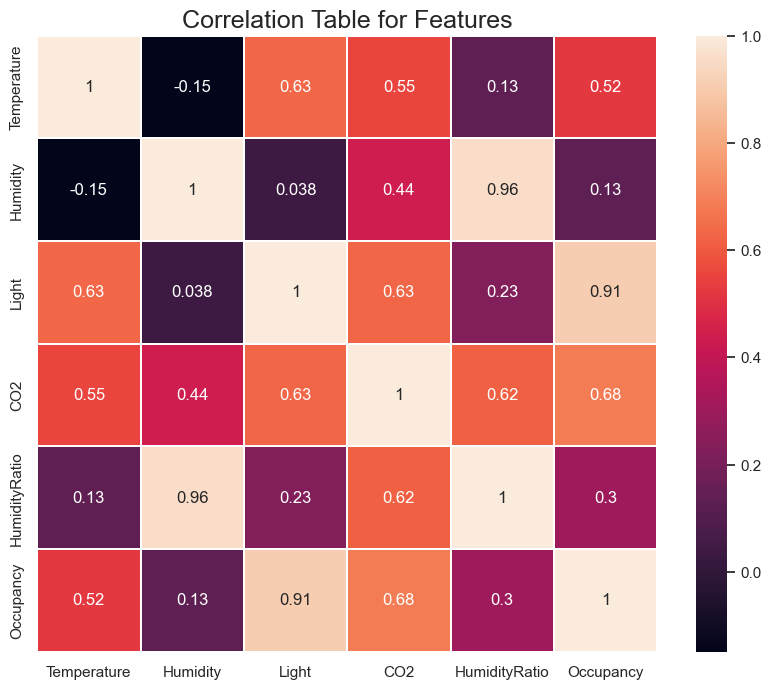

In [38]:
plt.figure(figsize=(10,8))
plt.title('Correlation Table for Features', fontdict={'fontsize':18})
ax = sns.heatmap(train.corr(), annot=True, linewidths=.2)

Doluluk ve diğerleri arasındaki korelasyonları görebiliriz. Beklediğimiz gibi, light değeri dolulukla diğerlerinden daha fazla ilişkilidir.

"date" ve "Occupancy" sütunlarını (axis=1) çıkartarak ve geri kalan sütunlar üzerinde istatistiksel özetini yazdıracak şekilde bir kutu grafiği çizilmesi sağladık.

       Temperature     Humidity        Light          CO2  HumidityRatio
count  8143.000000  8143.000000  8143.000000  8143.000000    8143.000000
mean      0.377075     0.401676     0.077292     0.118386       0.312576
std       0.235846     0.247233     0.125947     0.190759       0.224186
min       0.000000     0.000000     0.000000     0.000000       0.000000
25%       0.167464     0.154431     0.000000     0.016453       0.106304
50%       0.345694     0.423623     0.000000     0.026355       0.296338
75%       0.547847     0.616307     0.165795     0.118386       0.441308
max       1.000000     1.000000     1.000000     1.000000       1.000000


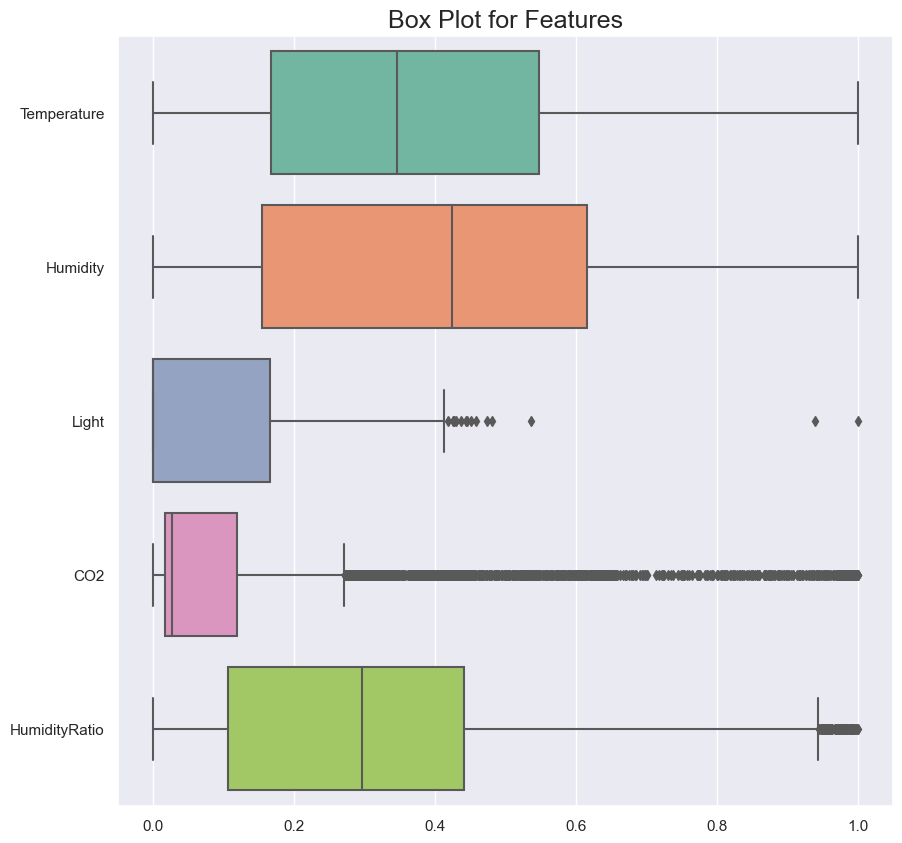

In [39]:
plt.figure(figsize=(10,10))
plt.title('Box Plot for Features', fontdict={'fontsize':18})
ax = sns.boxplot(data=train.drop(['date', 'Occupancy'],axis=1), orient="h", palette="Set2")
print(train.drop(['date', 'Occupancy'],axis=1).describe())

Oversampling yöntemi kullanarak nadir sınıfın temsil edilme oranı arttırdım.

In [40]:
from sklearn.utils import resample

# Azınlık sınıfa ait örnekleri seçin
minority_class_indices = train[train['Occupancy'] == 1].index

# Azınlık sınıfa ait örnekleri alın
minority_samples = train.loc[minority_class_indices]

# Azınlık sınıfa ait örnekleri artırın
oversampled_minority = resample(minority_samples, replace=True, n_samples=len(train[train['Occupancy'] == 0]), random_state=42)

# Çoğunluk sınıfı ile birleştirin
oversampled_data = pd.concat([train[train['Occupancy'] == 0], oversampled_minority])

# Veriyi karıştırabilirsiniz
oversampled_data = oversampled_data.sample(frac=1, random_state=42)

        Temperature      Humidity         Light           CO2  HumidityRatio
count  12828.000000  12828.000000  12828.000000  12828.000000   12828.000000
mean       0.463521      0.424608      0.157630      0.209565       0.359344
std        0.239407      0.260051      0.146830      0.243483       0.248112
min        0.000000      0.000000      0.000000      0.000000       0.000000
25%        0.287081      0.184155      0.000000      0.020888       0.159164
50%        0.452153      0.426640      0.254581      0.118386       0.316983
75%        0.667464      0.641636      0.293598      0.312471       0.517502
max        1.000000      1.000000      1.000000      1.000000       1.000000


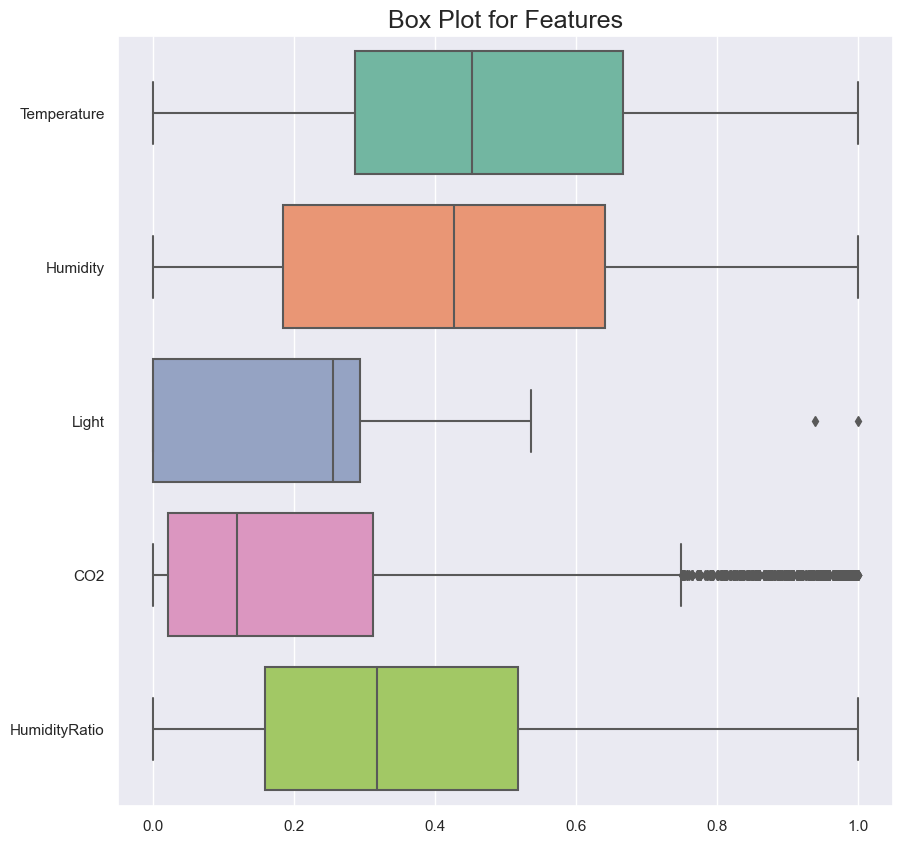

In [41]:
plt.figure(figsize=(10,10))
plt.title('Box Plot for Features', fontdict={'fontsize':18})
ax = sns.boxplot(data=oversampled_data.drop(['date', 'Occupancy'],axis=1), orient="h", palette="Set2")
print(oversampled_data.drop(['date', 'Occupancy'],axis=1).describe())

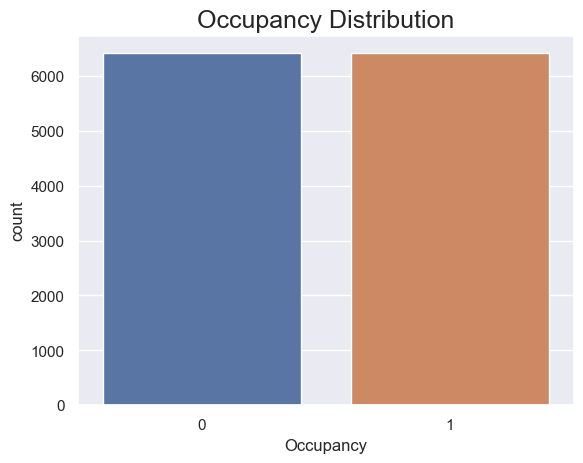

In [42]:
sns.set(style="darkgrid")
plt.title("Occupancy Distribution", fontdict={'fontsize':18})
ax = sns.countplot(x="Occupancy", data=oversampled_data)

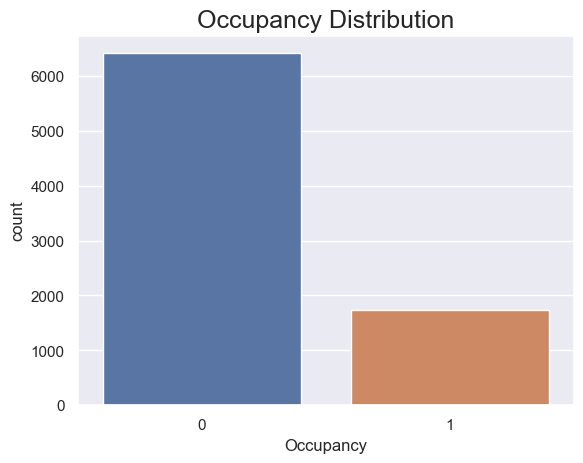

In [43]:
sns.set(style="darkgrid")
plt.title("Occupancy Distribution", fontdict={'fontsize':18})
ax = sns.countplot(x="Occupancy", data=train)

Verilerimiz dengesizdi, bu nedenle tahminlerimizi güçlendirmek için özellikler arasında başka bir ilişki de bulabiliriz. Bu noktada, doluluk ile günün saati arasında bir ilişki kurulabileceğini gözlemliyoruz.

### Yeni özellik üretimi

"hours_1", "Occupancy" sütunu 1 olan örneklerin saatlerini tutar, "hours_0" ise "Occupancy" sütunu 0 olan örneklerin saatlerini tutar. Bu sayede, doluluk durumunun günün hangi saatlerinde daha sık değiştiğini iki yoğunluk grafiği ile görselleştirdik.

In [44]:
hours_1 = []
hours_0 = []
for date in train[train['Occupancy'] == 1]['date']:
    hours_1.append(date.hour)
for date in train[train['Occupancy'] == 0]['date']:
    hours_0.append(date.hour)

C:\Users\skumsar\AppData\Local\anaconda3\envs\Projects\lib\site-packages\ipykernel_launcher.py:2: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\skumsar\AppData\Local\anaconda3\envs\Projects\lib\site-packages\ipykernel_launcher.py:3: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




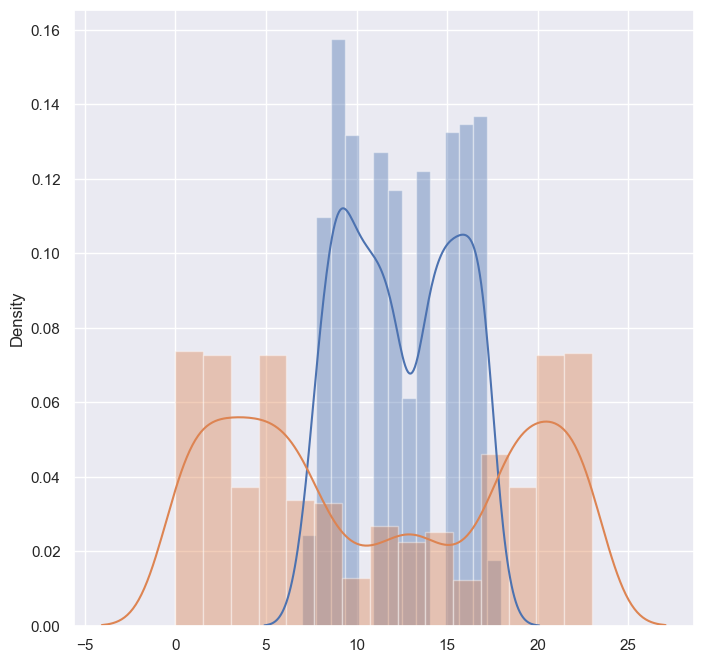

In [45]:
plt.figure(figsize=(8,8))
ax = sns.distplot(hours_1)
ax = sns.distplot(hours_0)

07:00 ile 17:00 saatleri arasında çevrede oturan var ya da yok. Ama sıra mesai dışı saatlere geldiğinde kesinlikle oturan yok diyebiliriz.

* 07:00 - 17:00 working hour (labeled as 1)
* rest of the day non-working hour (labeled as 0)


Her bir tarih değeri için saat değerini kontrol ederek, saatlerin 7 ile 17 arasında (gün içindeki iş saatleri) olup olmadığını belirler. Eğer saatler bu aralıktaysa, değer 1 olarak atanır; değilse, değer 0 olarak atanır.

In [46]:
dev['period_of_day'] = [1 if (i.hour >= 7 and i.hour <= 17) else 0 for i in dev['date']]
test['period_of_day'] = [1 if (i.hour >= 7 and i.hour <= 17) else 0 for i in test['date']]
train['period_of_day'] = [1 if (i.hour >= 7 and i.hour <= 17) else 0 for i in train['date']]
train.sample(10)

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,period_of_day
1306,2015-02-05 15:36:59,0.837321,0.475807,0.298125,0.405746,0.511315,1,1
6938,2015-02-09 13:28:59,0.526316,0.722092,0.008407,0.457321,0.645415,0,1
6794,2015-02-09 11:05:00,0.502392,0.732223,0.296185,0.598226,0.646402,1,1
393,2015-02-05 00:23:59,0.547847,0.377919,0.000000,0.118386,0.333498,0,0
6605,2015-02-09 07:56:00,0.119617,0.436026,0.000000,0.036670,0.272517,0,1
6463,2015-02-09 05:34:00,0.119617,0.444966,0.000000,0.029862,0.279926,0,0
1387,2015-02-05 16:58:00,0.787081,0.421500,0.286161,0.403528,0.442222,1,1
6849,2015-02-09 12:00:00,0.571770,0.747421,0.300065,0.645056,0.685060,1,1
1487,2015-02-05 18:38:00,0.377075,0.270198,0.000000,0.118386,0.239565,0,0
2302,2015-02-06 08:12:59,0.428230,0.121913,0.270964,0.082624,0.072362,1,1


       Temperature     Humidity        Light          CO2  HumidityRatio  \
count  8143.000000  8143.000000  8143.000000  8143.000000    8143.000000   
mean      0.377075     0.401676     0.077292     0.118386       0.312576   
std       0.235846     0.247233     0.125947     0.190759       0.224186   
min       0.000000     0.000000     0.000000     0.000000       0.000000   
25%       0.167464     0.154431     0.000000     0.016453       0.106304   
50%       0.345694     0.423623     0.000000     0.026355       0.296338   
75%       0.547847     0.616307     0.165795     0.118386       0.441308   
max       1.000000     1.000000     1.000000     1.000000       1.000000   

       period_of_day  
count    8143.000000  
mean        0.425273  
std         0.494415  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         1.000000  
max         1.000000  


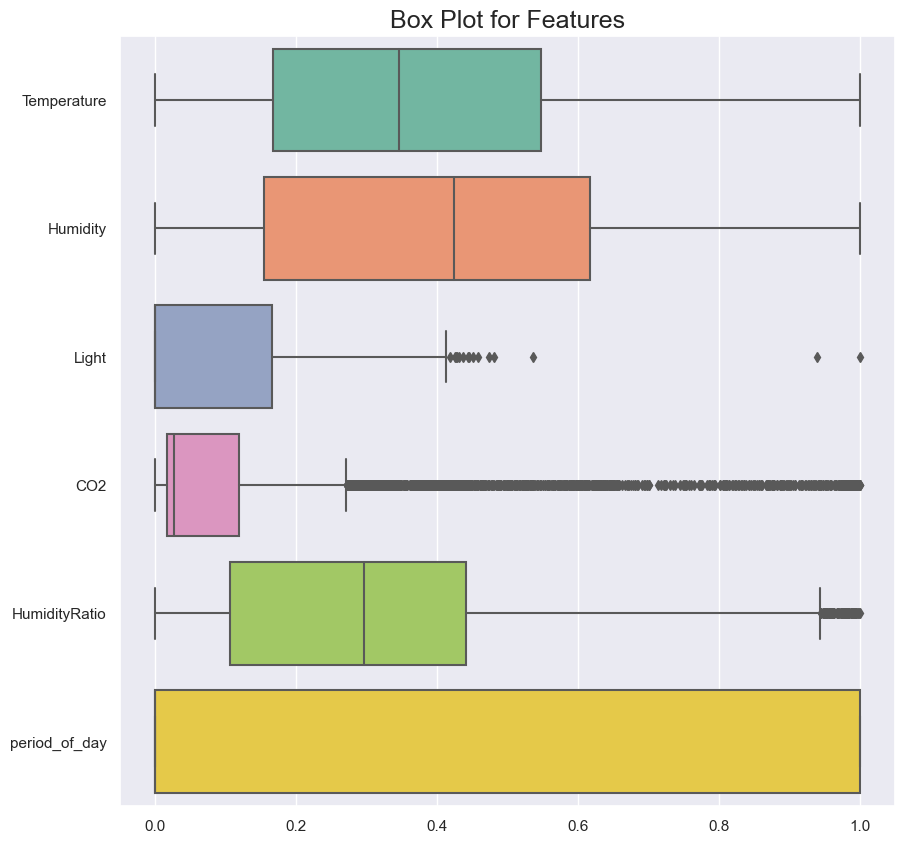

In [47]:
plt.figure(figsize=(10,10))
plt.title('Box Plot for Features', fontdict={'fontsize':18})
ax = sns.boxplot(data=train.drop(['date', 'Occupancy'],axis=1), orient="h", palette="Set2")
print(train.drop(['date', 'Occupancy'],axis=1).describe())

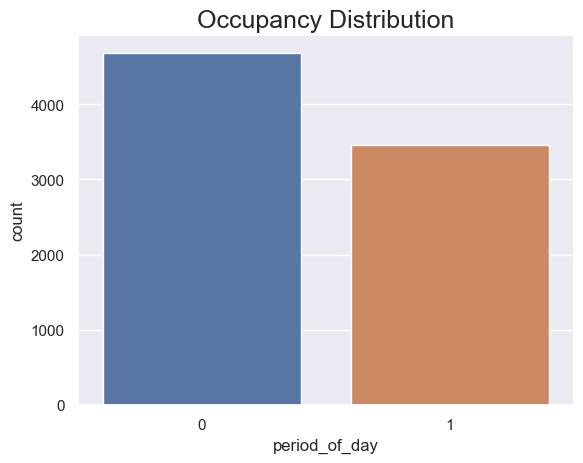

In [48]:
sns.set(style="darkgrid")
plt.title("Occupancy Distribution", fontdict={'fontsize':18})
ax = sns.countplot(x="period_of_day", data=train)

In [49]:
from sklearn.utils import resample

# Azınlık sınıfa ait örnekleri seçin
minority_class_indices = train[train['Occupancy'] == 1].index

# Azınlık sınıfa ait örnekleri alın
minority_samples = train.loc[minority_class_indices]

# Azınlık sınıfa ait örnekleri artırın
oversampled_minority = resample(minority_samples, replace=True, n_samples=len(train[train['Occupancy'] == 0]), random_state=42)

# Çoğunluk sınıfı ile birleştirin
oversampled_data = pd.concat([train[train['Occupancy'] == 0], oversampled_minority])

# Veriyi karıştırabilirsiniz
oversampled_data = oversampled_data.sample(frac=1, random_state=42)

        Temperature      Humidity         Light           CO2  HumidityRatio  \
count  12828.000000  12828.000000  12828.000000  12828.000000   12828.000000   
mean       0.463521      0.424608      0.157630      0.209565       0.359344   
std        0.239407      0.260051      0.146830      0.243483       0.248112   
min        0.000000      0.000000      0.000000      0.000000       0.000000   
25%        0.287081      0.184155      0.000000      0.020888       0.159164   
50%        0.452153      0.426640      0.254581      0.118386       0.316983   
75%        0.667464      0.641636      0.293598      0.312471       0.517502   
max        1.000000      1.000000      1.000000      1.000000       1.000000   

       period_of_day  
count   12828.000000  
mean        0.629560  
std         0.482941  
min         0.000000  
25%         0.000000  
50%         1.000000  
75%         1.000000  
max         1.000000  


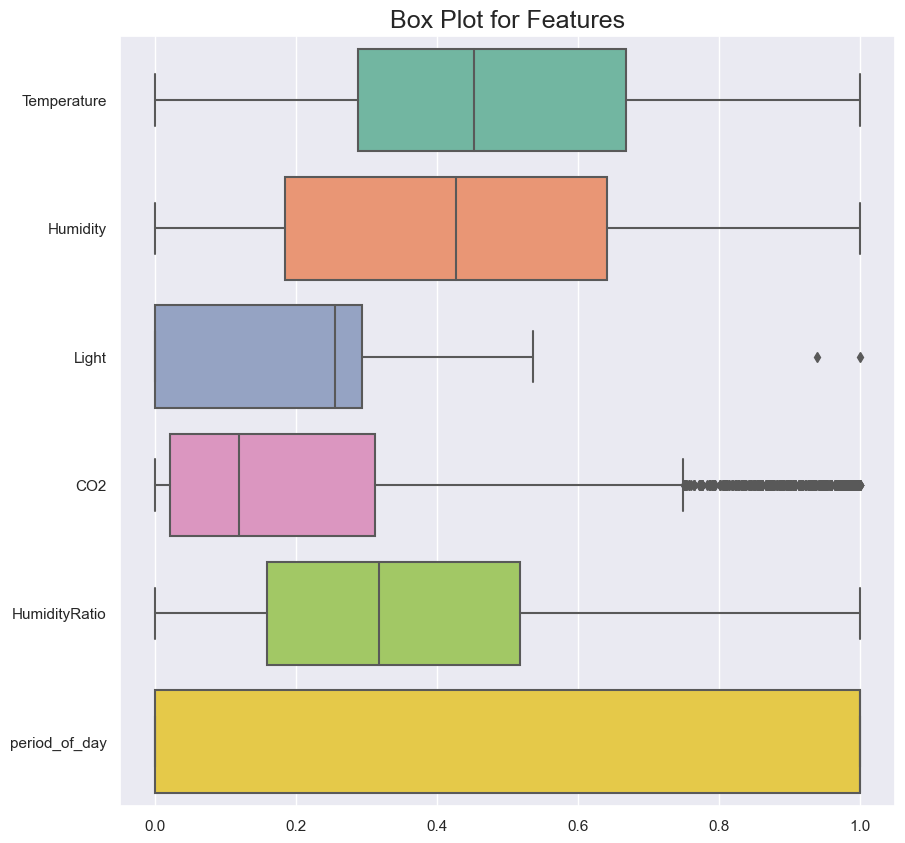

In [50]:
plt.figure(figsize=(10,10))
plt.title('Box Plot for Features', fontdict={'fontsize':18})
ax = sns.boxplot(data=oversampled_data.drop(['date', 'Occupancy'],axis=1), orient="h", palette="Set2")
print(oversampled_data.drop(['date', 'Occupancy'],axis=1).describe())

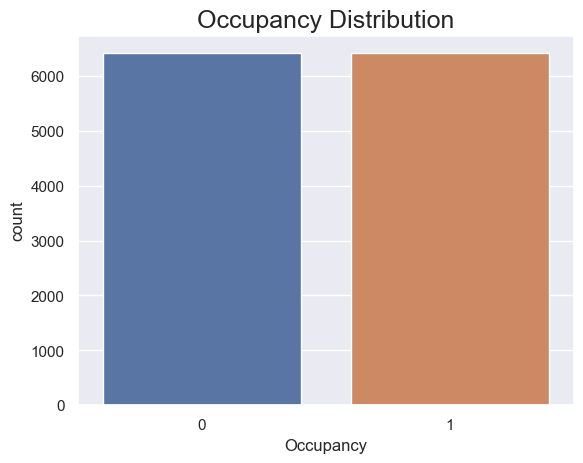

In [51]:
sns.set(style="darkgrid")
plt.title("Occupancy Distribution", fontdict={'fontsize':18})
ax = sns.countplot(x="Occupancy", data=oversampled_data)

# 5. Data Visualization
- Preprocessing sonrası EDA kısmının özeti şeklinde anlamlı olabilecek görselleştirmeler

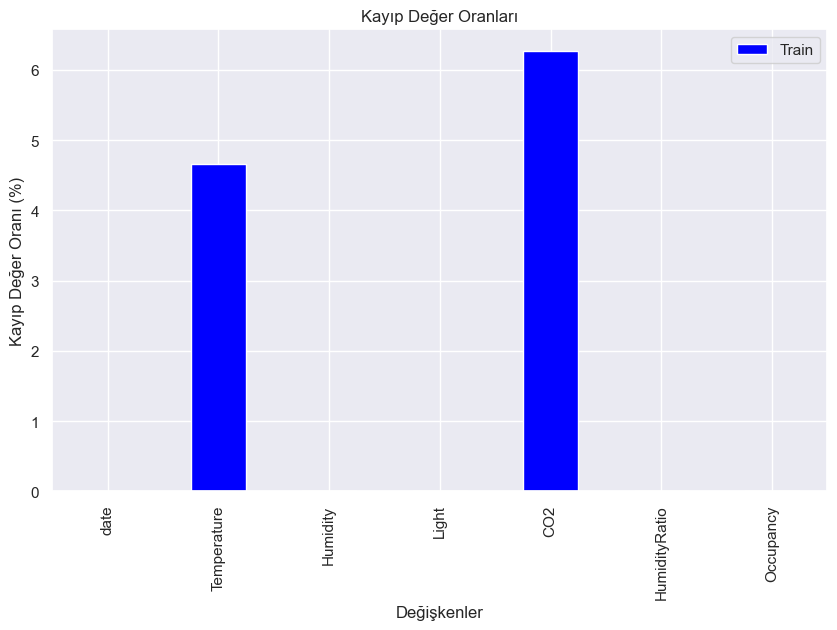

In [52]:
# Kayıp değer oranlarını hesapla
train_missing_percent = (train_missing_values / len(train)) * 100

# Sonuçları görselleştir
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

train_missing_percent.plot(kind='bar', color='blue', label='Train')


plt.title('Kayıp Değer Oranları')
plt.xlabel('Değişkenler')
plt.ylabel('Kayıp Değer Oranı (%)')
plt.legend()
plt.show()

In [53]:
train_missing_values2 = oversampled_data.isnull().sum()

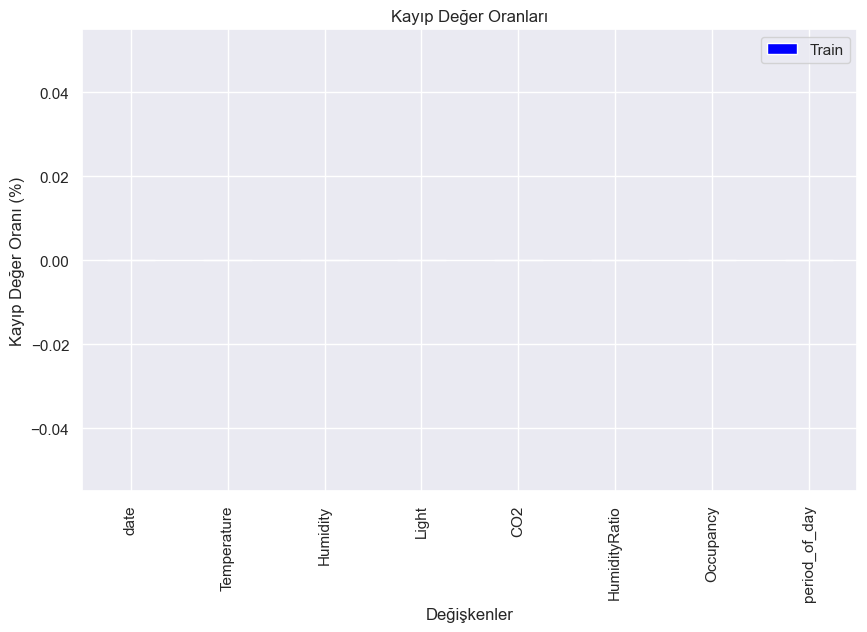

In [54]:
# Kayıp değer oranlarını hesapla
train_missing_percent2 = (train_missing_values2 / len(oversampled_data)) * 100

# Sonuçları görselleştir
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

train_missing_percent2.plot(kind='bar', color='blue', label='Train')


plt.title('Kayıp Değer Oranları')
plt.xlabel('Değişkenler')
plt.ylabel('Kayıp Değer Oranı (%)')
plt.legend()
plt.show()

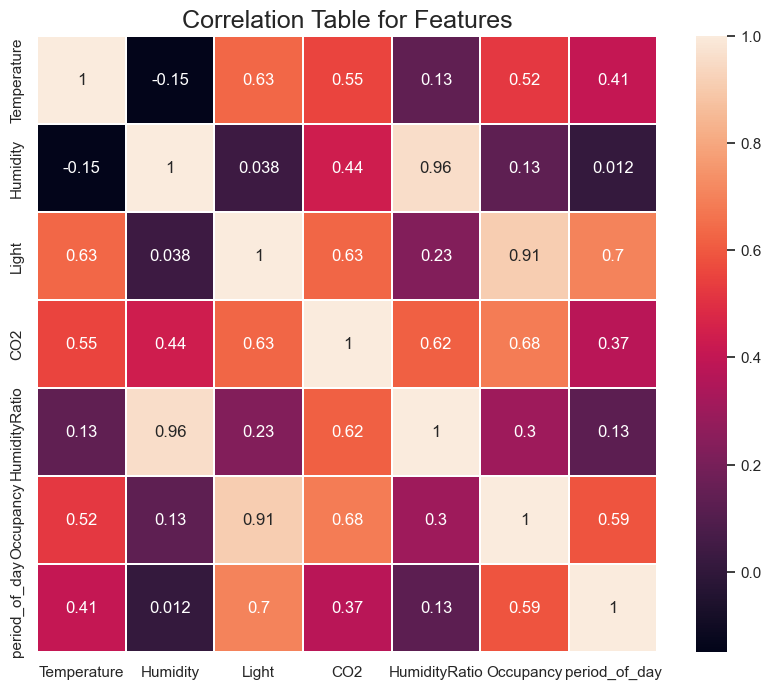

In [55]:
plt.figure(figsize=(10,8))
plt.title('Correlation Table for Features', fontdict={'fontsize':18})
ax = sns.heatmap(train.corr(), annot=True, linewidths=.2)

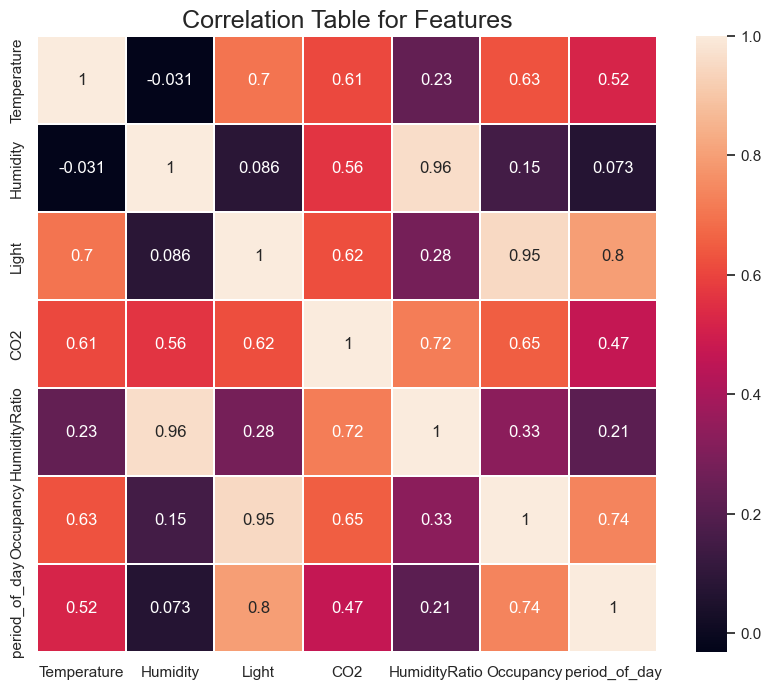

In [56]:
plt.figure(figsize=(10,8))
plt.title('Correlation Table for Features', fontdict={'fontsize':18})
ax = sns.heatmap(oversampled_data.corr(), annot=True, linewidths=.2)

       Temperature     Humidity        Light          CO2  HumidityRatio  \
count  8143.000000  8143.000000  8143.000000  8143.000000    8143.000000   
mean      0.377075     0.401676     0.077292     0.118386       0.312576   
std       0.235846     0.247233     0.125947     0.190759       0.224186   
min       0.000000     0.000000     0.000000     0.000000       0.000000   
25%       0.167464     0.154431     0.000000     0.016453       0.106304   
50%       0.345694     0.423623     0.000000     0.026355       0.296338   
75%       0.547847     0.616307     0.165795     0.118386       0.441308   
max       1.000000     1.000000     1.000000     1.000000       1.000000   

       period_of_day  
count    8143.000000  
mean        0.425273  
std         0.494415  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         1.000000  
max         1.000000  


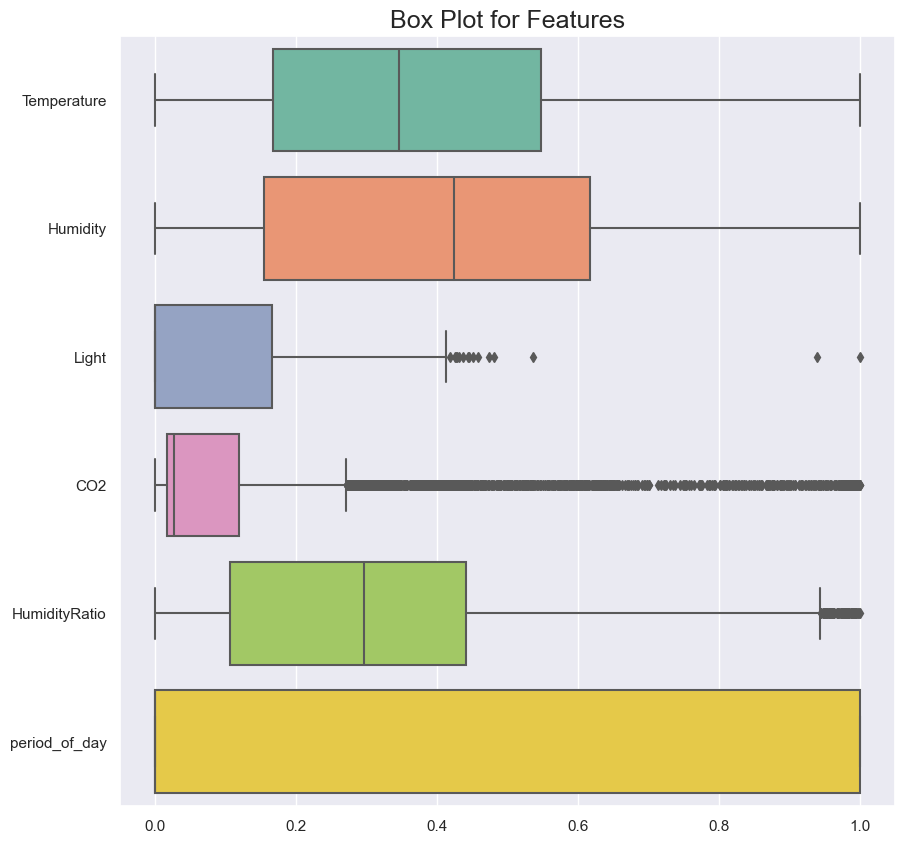

In [57]:
plt.figure(figsize=(10,10))
plt.title('Box Plot for Features', fontdict={'fontsize':18})
ax = sns.boxplot(data=train.drop(['date', 'Occupancy'],axis=1), orient="h", palette="Set2")
print(train.drop(['date', 'Occupancy'],axis=1).describe())

        Temperature      Humidity         Light           CO2  HumidityRatio  \
count  12828.000000  12828.000000  12828.000000  12828.000000   12828.000000   
mean       0.463521      0.424608      0.157630      0.209565       0.359344   
std        0.239407      0.260051      0.146830      0.243483       0.248112   
min        0.000000      0.000000      0.000000      0.000000       0.000000   
25%        0.287081      0.184155      0.000000      0.020888       0.159164   
50%        0.452153      0.426640      0.254581      0.118386       0.316983   
75%        0.667464      0.641636      0.293598      0.312471       0.517502   
max        1.000000      1.000000      1.000000      1.000000       1.000000   

       period_of_day  
count   12828.000000  
mean        0.629560  
std         0.482941  
min         0.000000  
25%         0.000000  
50%         1.000000  
75%         1.000000  
max         1.000000  


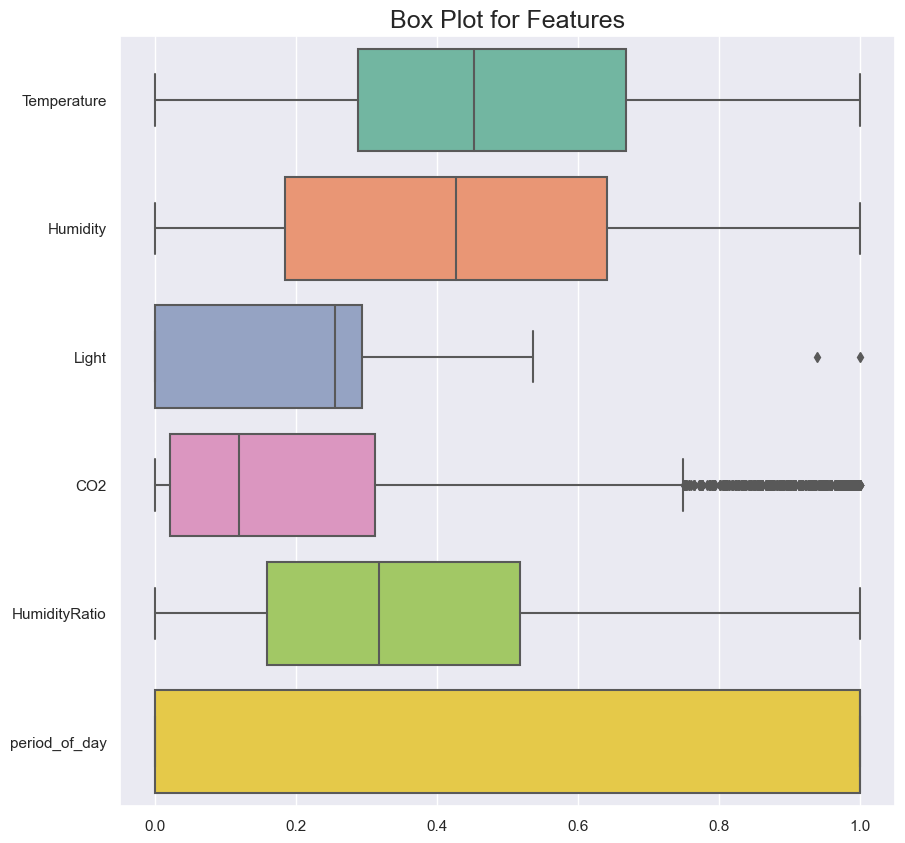

In [58]:
plt.figure(figsize=(10,10))
plt.title('Box Plot for Features', fontdict={'fontsize':18})
ax = sns.boxplot(data=oversampled_data.drop(['date', 'Occupancy'],axis=1), orient="h", palette="Set2")
print(oversampled_data.drop(['date', 'Occupancy'],axis=1).describe())

In [59]:
train = oversampled_data

# 6. Training
- **Yapay sinir ağları(keras,pytorch,tf kullanılabilir tercih size kalmış)** ve **Logistic Regression(scikit-learnden alınabilir)** ile sınıflandırma yapılması.
- algoritmalar seçilirken seçilmelerinin sebepleri olmalı ve eğitim sonrası gözlem alarak belirtilmeli
- Yapay sinir ağlarında train,dev,test accuracy-loss grafiklerinin çizdirilmesi ve aralıklara göre fit durumunun yorumlanması.( şu aralıklarda underfit, şu noktada fit, şuradan sonra overfit oluyor gibi yorumlar ya da son haliyle modelimiz overfit durumdadır gibi eklemeler..)

In [60]:
X_train = train.drop(columns=['date', 'Occupancy'], axis=1)
y_train = train['Occupancy']
X_validation = dev.drop(columns=['date', 'Occupancy'], axis=1)
y_validation = dev['Occupancy']
X_test = test.drop(columns=['date', 'Occupancy'], axis=1)
y_test = test['Occupancy']

"X_train" içinde eğitim veri seti için özellikleri temsil eden dataframe i tanımladık yani zaman ve doluluk dışındaki verileri train ettik, "Occupancy" sütununu seçerek eğitim veri seti için hedef değişkeni temsil eden "y_train" dataframe ini tanımladık. 

## 6.1. Makine Öğrenmesi Modelleri

### 6.1.1. KNN (K-Nearest Neighbors)

En iyi seçenekleri bulmak için KNN modelinde n_neighbors, ağırlıklar ve metrikler gibi farklı hiperparametreleri deneyelim.

In [61]:
# parameter-tuning for knn
n_neighbors_list = [7,15,45,135]
weights_list = ['uniform', 'distance']
metric_list = ['euclidean', 'manhattan']
accuracies = {}
for n in n_neighbors_list:
    for weight in weights_list:
        for metric in metric_list:
            knn_model = KNeighborsClassifier(n_neighbors=n, weights=weight, metric=metric)
            knn_model.fit(X_train, y_train)
            accuracy = knn_model.score(X_validation, y_validation)
            accuracies[str(n)+"/"+weight+"/"+metric] = accuracy

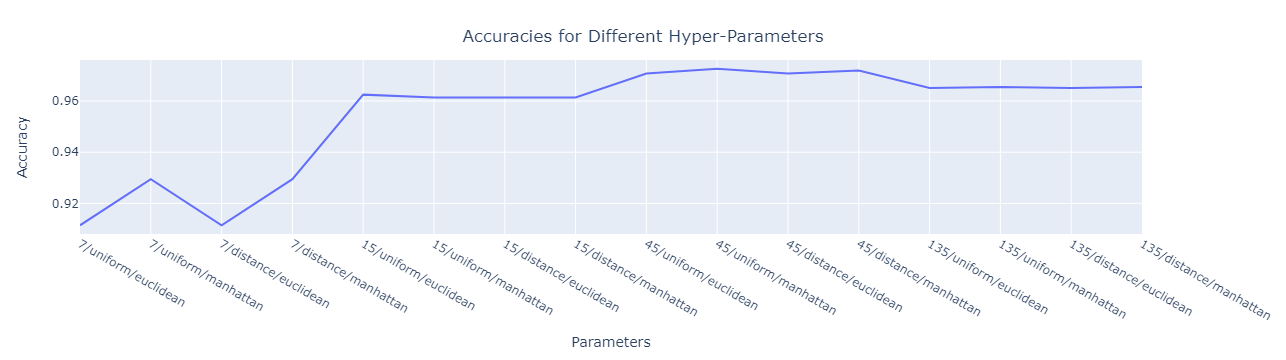

In [62]:
plotdata = pd.DataFrame()
plotdata['Parameters'] = accuracies.keys()
plotdata['Accuracy'] = accuracies.values()
fig = px.line(plotdata, x="Parameters", y="Accuracy")
fig.update_layout(title={'text': "Accuracies for Different Hyper-Parameters",
                                                'x':0.5,
                                                'xanchor': 'center',
                                                'yanchor': 'top'})
iplot(fig)

In [63]:
# En yüksek accuracy değerini ve karşılık gelen hiperparametre kombinasyonunu bulma
max_accuracy = max(accuracies.values())
best_hyperparameters = [param for param, accuracy in accuracies.items() if accuracy == max_accuracy]

print("Max Accuracy:", max_accuracy)
print("Best Hyperparameters:", best_hyperparameters)

Max Accuracy: 0.9726078799249531
Best Hyperparameters: ['45/uniform/manhattan']


Manhattan mesafesi (L1 mesafesi), veri noktalarının koordinatlarının mutlak farklarını kullanarak mesafeyi hesaplar. "uniform" ağırlıklar, tüm komşuların eşit ağırlığa sahip olduğu anlamına gelirken, "distance" ağırlıkları ise komşuların uzaklığına göre ağırlıklandırılacağı anlamına gelir. "Uniform" ağırlıkların daha iyi sonuç verdiğini gözlemlememiz de veri setinizin belirli bir komşu ağırlığı dağılımına daha iyi cevap verdiğini gösterebilir.

Doğruluk grafiğine bakarak:
* 45 k-değeri için yeterlidir.
* Best Hyperparameters: Manhattan distance daha iyi sonuç vermiştir. Uniform ağırlıklar daha iyidir.

In [64]:
# 6.1.1 KNN (K-Nearest Neighbors)
knn_model = KNeighborsClassifier(metric='manhattan', n_neighbors=45, weights='uniform')
knn_model.fit(X_train, y_train)
print("Accuracy for knn on validation data: %{}".format(round((knn_model.score(X_validation, y_validation)*100),2)))

Accuracy for knn on validation data: %97.26


### 6.1.2. SVM (Support-Vector Machine)

In [65]:
svm_model = SVC()
svm_model.fit(X_train, y_train)
print("Accuracy for SVM on validation data: {}%".format(round((svm_model.score(X_validation, y_validation)*100),2)))

Accuracy for SVM on validation data: 97.79%


### 6.1.3. Random Forest

In [66]:
RF=RandomForestClassifier(max_depth=20,n_estimators=200)
RF.fit(X_train,y_train)
print("Accuracy for RandomForest on validation data: {}%".format(round((RF.score(X_validation, y_validation)*100),2)))

Accuracy for RandomForest on validation data: 94.86%


### 6.1.4. AdaBoost

In [67]:
ada_clf = AdaBoostClassifier(n_estimators=100, random_state=42)
ada_clf.fit(X_train, y_train)
print("Accuracy for AdaBoost on validation data: {}%".format(round((ada_clf.score(X_validation, y_validation)*100),2)))

Accuracy for AdaBoost on validation data: 95.61%


### 6.1.5. CatBoost

In [68]:
cat_clf = CatBoostClassifier(iterations=100, learning_rate=0.1, loss_function='Logloss')
cat_clf.fit(X_train, y_train)
print("Accuracy for CatBoost on validation data: {}%".format(round((cat_clf.score(X_validation, y_validation)*100),2)))

0:	learn: 0.6029337	total: 146ms	remaining: 14.5s
1:	learn: 0.5285315	total: 157ms	remaining: 7.69s
2:	learn: 0.4667780	total: 165ms	remaining: 5.32s
3:	learn: 0.4141488	total: 168ms	remaining: 4.03s
4:	learn: 0.3695597	total: 172ms	remaining: 3.26s
5:	learn: 0.3308124	total: 177ms	remaining: 2.77s
6:	learn: 0.2975229	total: 182ms	remaining: 2.41s
7:	learn: 0.2680325	total: 186ms	remaining: 2.13s
8:	learn: 0.2421694	total: 190ms	remaining: 1.92s
9:	learn: 0.2194356	total: 194ms	remaining: 1.75s
10:	learn: 0.1995967	total: 198ms	remaining: 1.6s
11:	learn: 0.1819385	total: 203ms	remaining: 1.49s
12:	learn: 0.1661639	total: 209ms	remaining: 1.4s
13:	learn: 0.1523684	total: 217ms	remaining: 1.33s
14:	learn: 0.1398758	total: 227ms	remaining: 1.28s
15:	learn: 0.1286231	total: 236ms	remaining: 1.24s
16:	learn: 0.1187193	total: 245ms	remaining: 1.2s
17:	learn: 0.1098939	total: 252ms	remaining: 1.15s
18:	learn: 0.1018900	total: 258ms	remaining: 1.1s
19:	learn: 0.0950184	total: 263ms	remaining: 

### 6.1.6. XGBoost

In [69]:
xgb_clf = XGBClassifier(n_estimators=100, random_state=42)
xgb_clf.fit(X_train, y_train)
print("Accuracy for XGBoost on validation data: {}%".format(round((xgb_clf.score(X_validation, y_validation)*100),2)))

Accuracy for XGBoost on validation data: 95.16%


### 6.1.7. LightGBM

In [70]:
lightgbm_clf = lgb.LGBMClassifier()
lightgbm_clf.fit(X_train,y_train)
print("Accuracy for LightGBm  on validation data: %{}".format(round((lightgbm_clf.score(X_validation, y_validation)*100),2)))

[LightGBM] [Info] Number of positive: 6414, number of negative: 6414
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1212
[LightGBM] [Info] Number of data points in the train set: 12828, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Accuracy for LightGBm  on validation data: %94.11


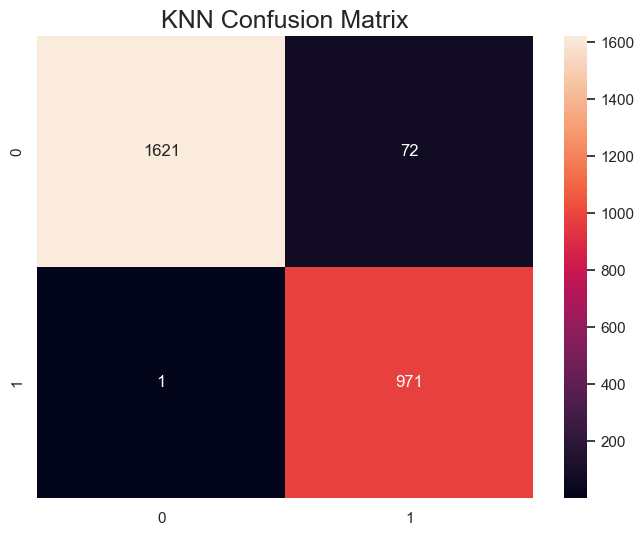

Accuracy for KNN on validation data: 97.26%


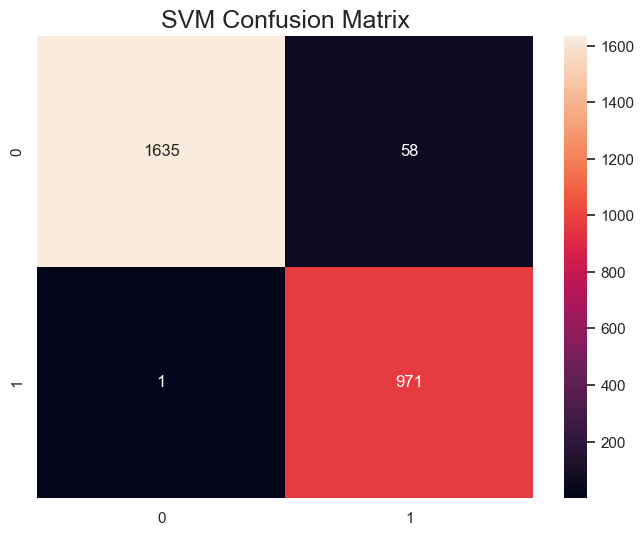

Accuracy for SVM on validation data: 97.79%


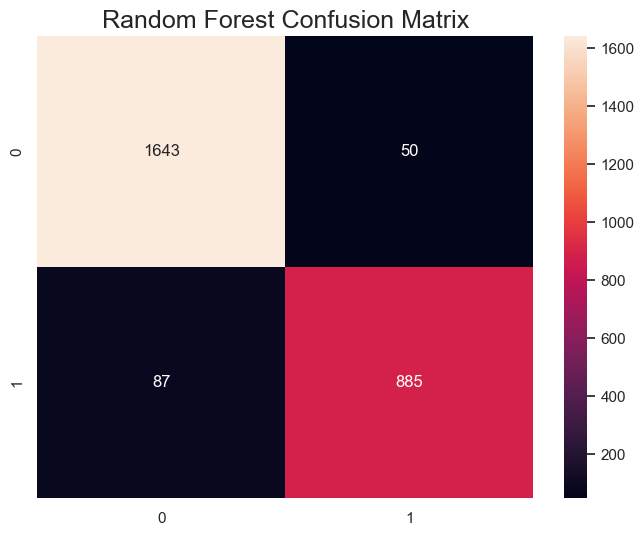

Accuracy for Random Forest on validation data: 94.86%


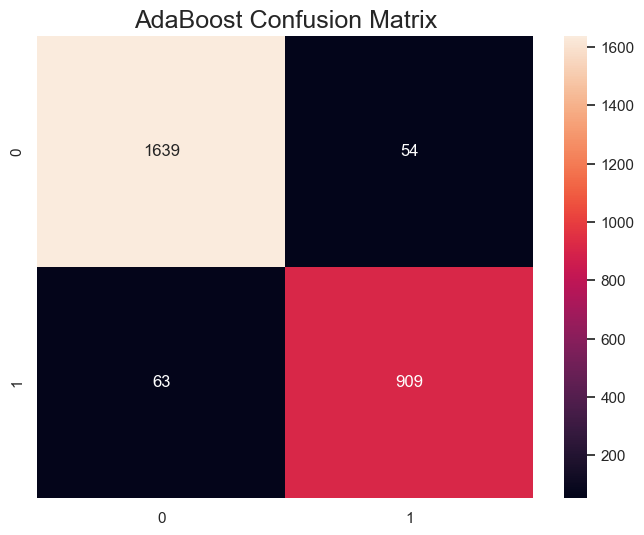

Accuracy for AdaBoost on validation data: 95.61%


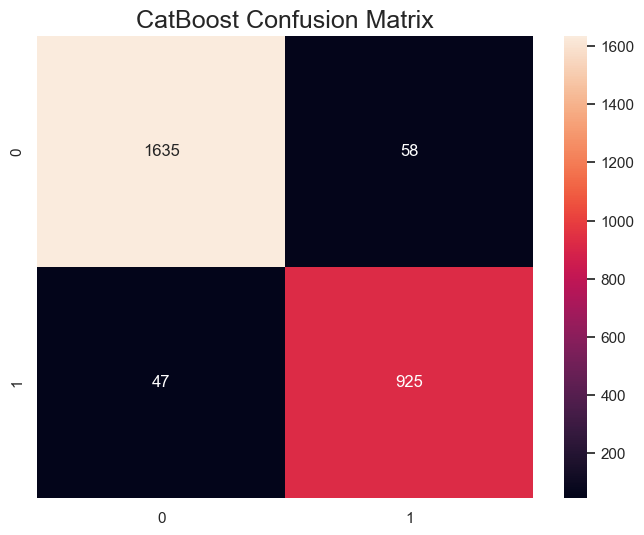

Accuracy for CatBoost on validation data: 96.06%


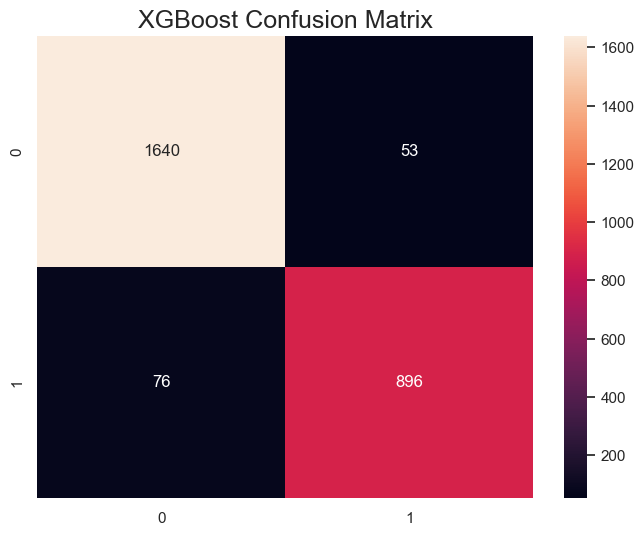

Accuracy for XGBoost on validation data: 95.16%


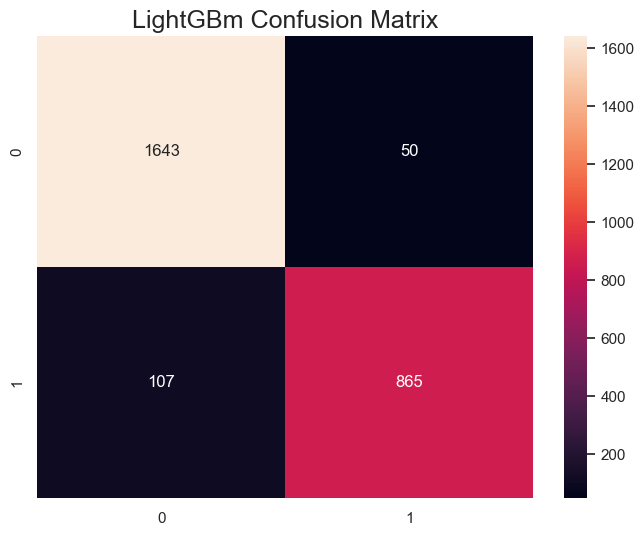

Accuracy for LightGBm on validation data: 94.11%


In [71]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

models = [knn_model, svm_model, RF, ada_clf, cat_clf, xgb_clf, lightgbm_clf]
model_names = ["KNN", "SVM", "Random Forest", "AdaBoost", "CatBoost", "XGBoost", "LightGBm"]

for model, model_name in zip(models, model_names):
    y_predict = model.predict(X_validation)
    cm = confusion_matrix(y_validation, y_predict)
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(cm, annot=True, fmt="d")
    plt.title(f"{model_name} Confusion Matrix", fontdict={'fontsize':18})
    plt.show()
    accuracy = model.score(X_validation, y_validation) * 100
    print(f"Accuracy for {model_name} on validation data: {accuracy:.2f}%")

Support-Vector Macine, Random Forest, boosting algortimalarını kullanarak modelleri train ettim. Makine Öğrenmesi modelleri arasında en iyi sonucu Support Vector Machine modelimiz verdi. Veri setimiz nümerik değerlerden oluştuğu için boosting algoritmalarımız geleneksel makine öğrenmesi modellerinin başarısının altında kaldılar.

## 6.2. Neural Networks

Öncelikle, düzenlileştirme yöntemleri olan veya olmayan farklı modeller denemek istiyorum. Dört farklı model oluşturacağım:
1. Without regularization
2. With 0.2 dropout regularization
3. With L1(Lasso) regularization
4. With L2(Ridge) regularization

Tüm modeller eğitilip doğrulama verileriyle değerlendirildikten sonra, eğitim ve doğrulama kayıplarını karşılaştıracağız.

### 6.2.1. Without regularization

In [72]:
# NN without regularization
model_without_regularization = Sequential()
model_without_regularization.add(Dense(32, activation='relu', input_dim=6))
model_without_regularization.add(Dense(16, activation='relu'))
model_without_regularization.add(Dense(1, activation='sigmoid'))
model_without_regularization.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                224       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________


Sequential sınıfı, sıralı bir sinir ağı modeli oluşturmamızı sağlar. Bu modelde katmanlar birbirine sırayla eklenir. add() methodu ile katmanlar modelimize eklenir. İlk katman girdi boyutunu belirlemek için input_dim parametresini alır. Bu katmanda 32 nöronlu gizli katman (ReLU aktivasyon fonksiyonu ile) ve ardından 16 nöronlu ikinci gizli katman bulunur. Son katman, 1 nöronlu çıkış katmanıdır ve sigmoid aktivasyon fonksiyonunu kullanır (çünkü ikili sınıflandırma yapıyoruz).

In [73]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
mc = ModelCheckpoint('model_without_regularization.h5', monitor='val_accuracy', mode='auto', verbose=1, save_best_only=True)

model_without_regularization.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train model
#model_without_regularization.fit(X_train, y_train, epochs=64, batch_size=32, validation_data=(X_validation, y_validation))
history_model_without_regularization = model_without_regularization.fit(X_train, y_train, epochs=64, batch_size=32, validation_data=(X_validation, y_validation), callbacks=[es, mc])

Epoch 1/64
382/401 [===========================>..] - ETA: 0s - loss: 0.2610 - accuracy: 0.9143
Epoch 1: val_accuracy improved from -inf to 0.96848, saving model to model_without_regularization.h5
401/401 [==============================] - 2s 4ms/step - loss: 0.2542 - accuracy: 0.9174 - val_loss: 0.1076 - val_accuracy: 0.9685
Epoch 2/64
380/401 [===========================>..] - ETA: 0s - loss: 0.0755 - accuracy: 0.9846
Epoch 2: val_accuracy did not improve from 0.96848
401/401 [==============================] - 1s 3ms/step - loss: 0.0743 - accuracy: 0.9848 - val_loss: 0.1019 - val_accuracy: 0.9685
Epoch 2: early stopping


Modeli kurma basamağına geçmeden önce aşırı öğrenmenin önüne geçmek adına EarlyStopping ve modelimizi kaydetmekle ilgili ModelCheckpoint ayarlarımızı gerçekleştirdik. monitor parametresi izlenecek metriği belirtir, mode izlenen metriği minimize etmek mi ('min') yoksa maksimize etmek mi ('max') belirtir. verbose ise erken durdurma süreci hakkında mesajları yazdırmayı denetler.

.compile() metodu, modelinizi derler. Burada optimizer, loss ve metrics parametreleri belirtilir. optimizer belirli bir optimizasyon algoritması (örneğin 'rmsprop'(Root Mean Square Propagation/Karelerin ortalamasının karekökü yayılımı)) kullanılacağını belirtir. loss, kayıp fonksiyonunu belirtir (burada 'binary_crossentropy' kullanıldı, çünkü ikili sınıflandırma yapılıyor). Modelin performansını değerlendirmek için eğitim parametrelerini epochs=64, batch_size=32 ayarlayarak accuracy sonucunu elde ettik.

### 6.2.2. With 0.2 dropout regularization

In [74]:
# List of dropout rates to try
dropout_rates = [0.0, 0.2, 0.4, 0.6]

# Dictionary to store validation accuracies for each dropout rate
validation_accuracies = {}

# Loop through different dropout rates
for dropout_rate in dropout_rates:
    model_with_dropout = Sequential()
    model_with_dropout.add(Dense(32, activation='relu', input_dim=6))
    model_with_dropout.add(Dropout(dropout_rate))
    model_with_dropout.add(Dense(16, activation='relu'))
    model_with_dropout.add(Dense(1, activation='sigmoid'))
    model_with_dropout.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    history = model_with_dropout.fit(X_train, y_train, epochs=64, batch_size=32, validation_data=(X_validation, y_validation))
    validation_accuracy = history.history['val_accuracy'][-1]  # Get the last validation accuracy
    validation_accuracies[dropout_rate] = validation_accuracy

# Find the dropout rate with the highest validation accuracy
best_dropout_rate = max(validation_accuracies, key=validation_accuracies.get)
print(f"Best Dropout Rate: {best_dropout_rate}, Validation Accuracy: {validation_accuracies[best_dropout_rate]}")

Epoch 1/64
401/401 [==============================] - 3s 4ms/step - loss: 0.2639 - accuracy: 0.9193 - val_loss: 0.1045 - val_accuracy: 0.9685
Epoch 2/64
401/401 [==============================] - 1s 3ms/step - loss: 0.0703 - accuracy: 0.9867 - val_loss: 0.1046 - val_accuracy: 0.9704
Epoch 3/64
401/401 [==============================] - 1s 3ms/step - loss: 0.0518 - accuracy: 0.9905 - val_loss: 0.1036 - val_accuracy: 0.9749
Epoch 4/64
401/401 [==============================] - 1s 3ms/step - loss: 0.0457 - accuracy: 0.9920 - val_loss: 0.0903 - val_accuracy: 0.9782
Epoch 5/64
401/401 [==============================] - 1s 3ms/step - loss: 0.0433 - accuracy: 0.9922 - val_loss: 0.1003 - val_accuracy: 0.9786
Epoch 6/64
401/401 [==============================] - 1s 3ms/step - loss: 0.0423 - accuracy: 0.9921 - val_loss: 0.0872 - val_accuracy: 0.9790
Epoch 7/64
401/401 [==============================] - 1s 3ms/step - loss: 0.0413 - accuracy: 0.9924 - val_loss: 0.0822 - val_accuracy: 0.9790
Epoch 

* Dropout katmanı her adımda belirtilen orandaki girdiyi rassal olarak sıfıra eşitleyerek modelin veriye aşırı uyum sağlamasının önüne geçer.

Best Dropout Rate: 0.2, Validation Accuracy: 0.9786116480827332

Dropout katmanı ekleyerek modelin aşırı uyumunu (overfitting) azaltarak daha iyi bir sonuç elde etmeyi hedefledik.

In [75]:
# NN with 0.2 dropout ratio before the hidden layer.
model_with_dropout = Sequential()
model_with_dropout.add(Dense(32, activation='relu', input_dim=6))
model_with_dropout.add(Dropout(0.2))
model_with_dropout.add(Dense(16, activation='relu'))
model_with_dropout.add(Dense(1, activation='sigmoid'))
model_with_dropout.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 32)                224       
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_16 (Dense)            (None, 16)                528       
                                                                 
 dense_17 (Dense)            (None, 1)                 17        
                                                                 
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________


In [76]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
mc = ModelCheckpoint('model_with_dropout.h5', monitor='val_accuracy', mode='auto', verbose=1, save_best_only=True)

model_with_dropout.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train model
#model_with_dropout.fit(X_train, y_train, epochs=64, batch_size=32, validation_data=(X_validation, y_validation))
history_model_with_dropout = model_with_dropout.fit(X_train, y_train, epochs=64, batch_size=32, validation_data=(X_validation, y_validation), callbacks=[es, mc])

Epoch 1/64
395/401 [============================>.] - ETA: 0s - loss: 0.3006 - accuracy: 0.9077
Epoch 1: val_accuracy improved from -inf to 0.96886, saving model to model_with_dropout.h5
401/401 [==============================] - 2s 2ms/step - loss: 0.2981 - accuracy: 0.9082 - val_loss: 0.1163 - val_accuracy: 0.9689
Epoch 2/64
393/401 [============================>.] - ETA: 0s - loss: 0.0948 - accuracy: 0.9754
Epoch 2: val_accuracy improved from 0.96886 to 0.97036, saving model to model_with_dropout.h5
401/401 [==============================] - 1s 2ms/step - loss: 0.0942 - accuracy: 0.9755 - val_loss: 0.1222 - val_accuracy: 0.9704
Epoch 2: early stopping


### 6.2.3. With L1(Lasso) regularization

Regularization (Düzenleme) : Düzenleme, modelin karmaşıklığını azaltmak için bir kullanılan tekniktir. Bunu kayıp fonksiyonunu cezalandırarak yapar. Yani modelde ağırlığı yüksek olan değişkenlerin ağırlığını azaltarak bu değişkenlerin etki oranını azaltır. Bu yöntem, aşırı öğrenme probleminin çözülmesine yardımcı olur.

Lasso Regresyon (L1 regularization): 
Modelin kayıp fonksiyonuna katsayıların mutlak değerlerinin toplamını ekleyerek gerçekleştirilir. L1 düzenlileştirmesi özellikle düzensiz özellik dağılımına sahip verilerde veya düşük boyutlu verilerde etkili olabilir.

In [77]:
# NN with L1(Lasso) regularization
model_with_l1_regularization  = Sequential()
model_with_l1_regularization.add(Dense(32, activation='relu', input_dim=6, kernel_regularizer=l1(l=0.01)))
model_with_l1_regularization.add(Dense(16, activation='relu', kernel_regularizer=l1(l=0.01)))
model_with_l1_regularization.add(Dense(1, activation='sigmoid'))
model_with_l1_regularization.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 32)                224       
                                                                 
 dense_19 (Dense)            (None, 16)                528       
                                                                 
 dense_20 (Dense)            (None, 1)                 17        
                                                                 
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________


In [78]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
mc = ModelCheckpoint('model_with_l1_regularization.h5', monitor='val_accuracy', mode='auto', verbose=1, save_best_only=True)

model_with_l1_regularization.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train model
#model_with_l1_regularization.fit(X_train, y_train, epochs=64, batch_size=32, validation_data=(X_validation, y_validation))
history_model_with_l1_regularization = model_with_l1_regularization.fit(X_train, y_train, epochs=64, batch_size=32, validation_data=(X_validation, y_validation), callbacks=[es, mc])

Epoch 1/64
378/401 [===========================>..] - ETA: 0s - loss: 0.9771 - accuracy: 0.8589
Epoch 1: val_accuracy improved from -inf to 0.95009, saving model to model_with_l1_regularization.h5
401/401 [==============================] - 2s 2ms/step - loss: 0.9490 - accuracy: 0.8623 - val_loss: 0.4145 - val_accuracy: 0.9501
Epoch 2/64
391/401 [============================>.] - ETA: 0s - loss: 0.4010 - accuracy: 0.9509
Epoch 2: val_accuracy improved from 0.95009 to 0.96886, saving model to model_with_l1_regularization.h5
401/401 [==============================] - 1s 2ms/step - loss: 0.4001 - accuracy: 0.9507 - val_loss: 0.3253 - val_accuracy: 0.9689
Epoch 2: early stopping


### 6.2.4. Wtih L2(Ridge) Regularization

Ridge Regresyon (L2 regularization): Modelin kayıp fonksiyonuna katsayıların karesinin toplamını ekleyerek gerçekleştirir. Over-fittinge karşı daha dirençlidir. Çok boyutluluğa çözüm sunar. Tüm değişkenler ile model kurar, ilgisiz değişkenleri çıkarmaz sadece katsayılarını sıfıra yaklaştırır.

In [79]:
# NN with L2(Ridge) Regularization
model_with_l2_regularization = Sequential()
model_with_l2_regularization.add(Dense(32, activation='relu', input_dim=6, kernel_regularizer=l2(l=0.01)))
model_with_l2_regularization.add(Dense(16, activation='relu', kernel_regularizer=l2(l=0.01)))
model_with_l2_regularization.add(Dense(1, activation='sigmoid'))
model_with_l2_regularization.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 32)                224       
                                                                 
 dense_22 (Dense)            (None, 16)                528       
                                                                 
 dense_23 (Dense)            (None, 1)                 17        
                                                                 
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________


In [80]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
mc = ModelCheckpoint('model_with_l1_regularization.h5', monitor='val_accuracy', mode='auto', verbose=1, save_best_only=True)

model_with_l2_regularization.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train model
#model_with_l2_regularization.fit(X_train, y_train, epochs=64, batch_size=32, validation_data=(X_validation, y_validation))
history_model_with_l2_regularization = model_with_l2_regularization.fit(X_train, y_train, epochs=64, batch_size=32, validation_data=(X_validation, y_validation), callbacks=[es, mc])

Epoch 1/64
379/401 [===========================>..] - ETA: 0s - loss: 0.4720 - accuracy: 0.9042
Epoch 1: val_accuracy improved from -inf to 0.96886, saving model to model_with_l1_regularization.h5
401/401 [==============================] - 2s 3ms/step - loss: 0.4605 - accuracy: 0.9079 - val_loss: 0.2436 - val_accuracy: 0.9689
Epoch 2/64
366/401 [==========================>...] - ETA: 0s - loss: 0.2263 - accuracy: 0.9684
Epoch 2: val_accuracy did not improve from 0.96886
401/401 [==============================] - 1s 2ms/step - loss: 0.2228 - accuracy: 0.9691 - val_loss: 0.2043 - val_accuracy: 0.9689
Epoch 2: early stopping


Epoch 1/64
401/401 [==============================] - 2s 2ms/step - loss: 0.9454 - accuracy: 0.8833 - val_loss: 0.4048 - val_accuracy: 0.9692
Epoch 2/64
401/401 [==============================] - 1s 2ms/step - loss: 0.3816 - accuracy: 0.9575 - val_loss: 0.3234 - val_accuracy: 0.9689
Epoch 3/64
401/401 [==============================] - 1s 2ms/step - loss: 0.3039 - accuracy: 0.9673 - val_loss: 0.2696 - val_accuracy: 0.9689
Epoch 4/64
401/401 [==============================] - 1s 2ms/step - loss: 0.2535 - accuracy: 0.9717 - val_loss: 0.2409 - val_accuracy: 0.9689
Epoch 5/64
401/401 [==============================] - 1s 2ms/step - loss: 0.2262 - accuracy: 0.9770 - val_loss: 0.2231 - val_accuracy: 0.9685
Epoch 6/64
401/401 [==============================] - 1s 2ms/step - loss: 0.2074 - accuracy: 0.9793 - val_loss: 0.2127 - val_accuracy: 0.9704
Epoch 7/64
401/401 [==============================] - 1s 2ms/step - loss: 0.1923 - accuracy: 0.9819 - val_loss: 0.2015 - val_accuracy: 0.9700
Epoch 

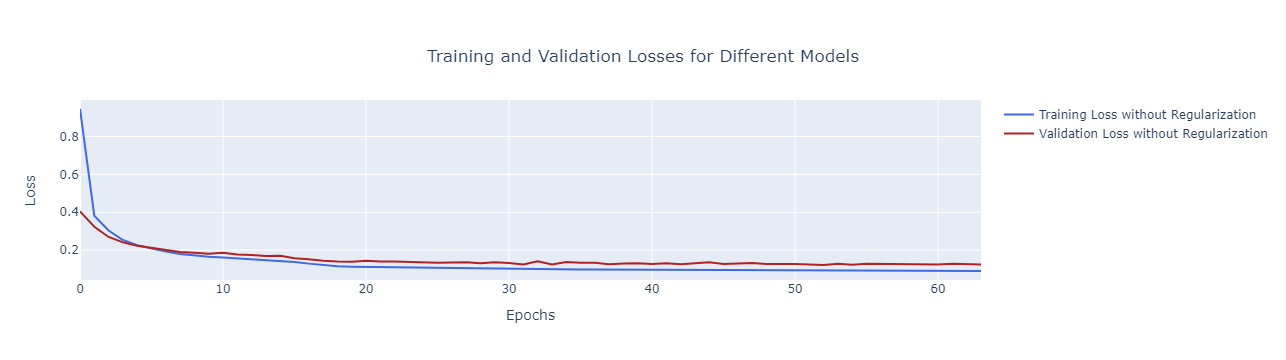

In [81]:
# NN with L1(Lasso) regularization
model_with_l1_regularization_over  = Sequential()
model_with_l1_regularization_over.add(Dense(32, activation='relu', input_dim=6, kernel_regularizer=l1(l=0.01)))
model_with_l1_regularization_over.add(Dense(16, activation='relu', kernel_regularizer=l1(l=0.01)))
model_with_l1_regularization_over.add(Dense(1, activation='sigmoid'))
model_with_l1_regularization_over.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train model
history_model_with_l1_regularization_over = model_with_l1_regularization_over.fit(X_train, y_train, epochs=64, batch_size=32, validation_data=(X_validation, y_validation))
loss1_over = history_model_with_l1_regularization_over.history['loss']
val_loss1_over = history_model_with_l1_regularization_over.history['val_loss']

fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(len(loss1_over)), y=loss1_over,
                    name='Training Loss without Regularization', line=dict(color='royalblue')))
fig.add_trace(go.Scatter(x=np.arange(len(val_loss1_over)), y=val_loss1_over,
                    name='Validation Loss without Regularization', line = dict(color='firebrick')))
fig.update_layout(xaxis_title='Epochs',
                  yaxis_title='Loss',
                  title={'text': "Training and Validation Losses for Different Models",
                                                'x':0.5,
                                                'xanchor': 'center',
                                                'yanchor': 'top'})
iplot(fig)

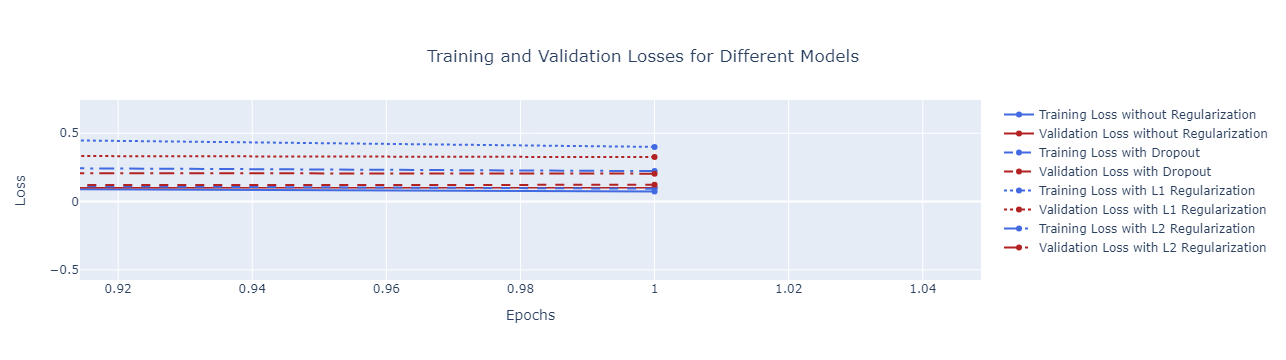

In [82]:
loss1 = history_model_without_regularization.history['loss']
val_loss1 = history_model_without_regularization.history['val_loss']
loss2 = history_model_with_dropout.history['loss']
val_loss2 = history_model_with_dropout.history['val_loss']
loss3 = history_model_with_l1_regularization.history['loss']
val_loss3 = history_model_with_l1_regularization.history['val_loss']
loss4 = history_model_with_l2_regularization.history['loss']
val_loss4 = history_model_with_l2_regularization.history['val_loss']


fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(len(loss1)), y=loss1,
                    name='Training Loss without Regularization', line=dict(color='royalblue')))
fig.add_trace(go.Scatter(x=np.arange(len(val_loss1)), y=val_loss1,
                    name='Validation Loss without Regularization', line = dict(color='firebrick')))

fig.add_trace(go.Scatter(x=np.arange(len(loss2)), y=loss2,
                    name='Training Loss with Dropout', line=dict(color='royalblue', dash='dash')))
fig.add_trace(go.Scatter(x=np.arange(len(val_loss2)), y=val_loss2,
                    name='Validation Loss with Dropout', line = dict(color='firebrick', dash='dash')))

fig.add_trace(go.Scatter(x=np.arange(len(loss3)), y=loss3,
                    name='Training Loss with L1 Regularization', line=dict(color='royalblue', dash='dot')))
fig.add_trace(go.Scatter(x=np.arange(len(val_loss3)), y=val_loss3,
                    name='Validation Loss with L1 Regularization', line = dict(color='firebrick', dash='dot')))

fig.add_trace(go.Scatter(x=np.arange(len(loss4)), y=loss4,
                    name='Training Loss with L2 Regularization', line=dict(color='royalblue', dash='longdashdot')))
fig.add_trace(go.Scatter(x=np.arange(len(val_loss4)), y=val_loss4,
                    name='Validation Loss with L2 Regularization', line = dict(color='firebrick', dash='longdashdot')))


fig.update_layout(xaxis_title='Epochs',
                  yaxis_title='Loss',
                  title={'text': "Training and Validation Losses for Different Models",
                                                'x':0.5,
                                                'xanchor': 'center',
                                                'yanchor': 'top'})
iplot(fig)

İlk başta EarlyStopping kullanmadan validation loss değerleri ile train loss değerlerini karşılaştırıldığımda validation loss değerlerinin daha yüksekte olduğunu gözlemledim. Bu durum veriyi aşırı ezberlediğini yani overfitting etkisi yarattığını göstermiştir. Daha önceden veri dağılımını dengelemek için kullandığım Oversampling yani azınlık sınıf etiketi örneklerini sayısı arttırmanın iyi sonuçlar getirmediğini gözlemledim.

En fazla kayıp değer içeren model L1 Lasso Regularization oldu.
Dropout(model_with_dropout) modelimiz overfitting olmaya fazlasıyla yatkın bir model olduğu için L2 Ridge Regularization modelinin en uygun model olduğunu söyleyebilirim.

### CNN (Convolutional Neural Networks)

In [83]:
print(X_train.shape)

(12828, 6)


Sequential sınıfını kullanarak bir model oluşturulur. Modelin ilk katmanı olarak bir Convolutional katmanı (Conv1D) eklenir. Bu katmanda 64 filtre kullanılır, filtre boyutu 3'tür ve aktivasyon fonksiyonu olarak ReLU kullanılır. input_shape parametresi, giriş verisinin şeklini belirtir ve bu örnekte (6, 1) olarak belirlenir. Bu, 6 özellikten oluşan 1 boyutlu bir giriş verisi olduğunu gösterir. MaxPooling katmanı (MaxPooling1D) eklenir. Bu katman, girdi boyutunu küçültmek ve özellikleri vurgulamak için kullanılır. pool_size parametresini 2 olarak belirttim. Flatten katmanı ekledim. Bu katman, Convolutional ve MaxPooling katmanlarının çıktılarını düzleştirerek bir vektör haline getirir. Böylece, bu vektör doğrusal bir katmana beslenebilir. Düzleştirme katmanından sonra tam bağlantılı (fully connected) katmanlar eklenir. İlk katmanda 64 nöron vardır ve ReLU aktivasyon fonksiyonu kullandım. İkinci katmanda 32 nöron bulunur. Son katman ise bir nörona sahiptir ve sonuç olarak bir sınıflandırma yapar. summary() fonksiyonu, oluşturulan modelin özetini ekrana yazdırır. Bu özet, her katmanın türünü, çıktı şeklini ve parametre sayısını gösterir.

In [84]:
import keras
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

model_cnn = keras.Sequential()

model_cnn.add(Conv1D(64, kernel_size=3, activation="relu", input_shape=(6,1)))
model_cnn.add(MaxPooling1D(pool_size=2))

model_cnn.add(Flatten())
model_cnn.add(Dense(64, activation="relu"))
model_cnn.add(Dense(32))
model_cnn.add(Dense(1))

model_cnn.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 64)             256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2, 64)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense_27 (Dense)            (None, 64)                8256      
                                                                 
 dense_28 (Dense)            (None, 32)                2080      
                                                                 
 dense_29 (Dense)            (None, 1)                 33        
                                                      

In [85]:
# Compile model
model_cnn.compile(loss="mean_squared_error", optimizer="adam", metrics=["accuracy"])
# Train model
model_cnn.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_validation, y_validation))

Epoch 1/50
401/401 [==============================] - 2s 3ms/step - loss: 0.0332 - accuracy: 0.9719 - val_loss: 0.0223 - val_accuracy: 0.9786
Epoch 2/50
401/401 [==============================] - 1s 2ms/step - loss: 0.0114 - accuracy: 0.9922 - val_loss: 0.0222 - val_accuracy: 0.9782
Epoch 3/50
401/401 [==============================] - 1s 2ms/step - loss: 0.0101 - accuracy: 0.9926 - val_loss: 0.0222 - val_accuracy: 0.9775
Epoch 4/50
401/401 [==============================] - 1s 2ms/step - loss: 0.0092 - accuracy: 0.9924 - val_loss: 0.0212 - val_accuracy: 0.9764
Epoch 5/50
401/401 [==============================] - 1s 2ms/step - loss: 0.0086 - accuracy: 0.9925 - val_loss: 0.0223 - val_accuracy: 0.9749
Epoch 6/50
401/401 [==============================] - 1s 2ms/step - loss: 0.0079 - accuracy: 0.9924 - val_loss: 0.0218 - val_accuracy: 0.9719
Epoch 7/50
401/401 [==============================] - 1s 2ms/step - loss: 0.0079 - accuracy: 0.9927 - val_loss: 0.0215 - val_accuracy: 0.9715
Epoch 

### LSTM

In [86]:
from keras import backend as K 
K.clear_session()

Keras'ta mevcut TensorFlow grafiğini temizlemek ve oturumu sıfırlamak için clear fonksiyonunu çağırdım. Gerekli kütüphaneleri tanımladım.
Veri setini daha önceden 3 boyutlu olarak ayarlamıştık. Eğer düzgün olmasaydı Numpy içerisindeki reshape i kullanarak veri setinin 3 boyutlu olmasını sağlayacaktık

Modelimiz 32 nörondan oluşan bir LSTM katmanı, aktivayson fonksiyonu olarak relu seçtim. Modelin giriş şekli (6, 1) input dizilerini beklediğini gösterir. Ardından dropout oranı 0.2 olan bir dropout katmanı ve 1 birimlik bir dense(çıkış) katmanından oluşmaktadır. 

In [87]:
from keras.layers import Dense, Dropout, LSTM

model_LSTM_1 = keras.Sequential()
model_LSTM_1.add(LSTM(units = 32,
               activation = 'relu',
               input_shape=(6,1)))
model_LSTM_1.add(Dropout(0.2))
model_LSTM_1.add(Dense(1))
model_LSTM_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


Modeli kurma basamağına geçmeden önce aşırı öğrenmenin önüne geçmek adına EarlyStopping ve modelimizi kaydetmekle ilgili ModelCheckpoint ayarlarımızı gerçekleştirdik. Loss fonksiyonunda "mean_squared_error"  ve optimize etmek için Adam fonksiyonunu kullanarak 0.001 lik learning_rate verdik. Modelin validasyon setindeki konfüzyon matrisi gösterimi bu şekildedir.

In [93]:
import tensorflow as tf

# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
mc = ModelCheckpoint('model_LSTM_1.h5', monitor='val_accuracy', mode='auto', verbose=1, save_best_only=True)
# Compile model
model_LSTM_1.compile(loss="mean_squared_error", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])
# Train model
#model_LSTM_1.fit(X_train, y_train, epochs=64, batch_size=32, validation_data=(X_validation, y_validation))
history_LSTM_1 = model_LSTM_1.fit(X_train, y_train, epochs=64, batch_size=32, validation_data=(X_validation, y_validation), callbacks=[es, mc])

Epoch 1/64
394/401 [============================>.] - ETA: 0s - loss: 0.0190 - accuracy: 0.9905
Epoch 1: val_accuracy improved from -inf to 0.97073, saving model to model_LSTM_1.h5
401/401 [==============================] - 3s 5ms/step - loss: 0.0190 - accuracy: 0.9904 - val_loss: 0.0266 - val_accuracy: 0.9707
Epoch 2/64
394/401 [============================>.] - ETA: 0s - loss: 0.0168 - accuracy: 0.9918
Epoch 2: val_accuracy did not improve from 0.97073
401/401 [==============================] - 2s 5ms/step - loss: 0.0166 - accuracy: 0.9920 - val_loss: 0.0267 - val_accuracy: 0.9707
Epoch 2: early stopping


### GRU(Gated Recurrent Units)

In [94]:
K.clear_session()

Bu model 32 nörondan oluşan GRU katmanından oluşmaktadır. Aynı şekilde 0.2 oranında dropout uyguladık. EarlyStopping ve ModelCheckpoint ayarlarımızı yaptık. Modelimizi optimize etmek için Adam ve 0.001'lik bir öğrenme oranı kullandık. 

In [95]:
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout

model_GRU_1 = Sequential()
model_GRU_1.add(GRU(units=32, activation='relu', input_shape=(6,1)))

model_GRU_1.add(Dropout(0.2))
model_GRU_1.add(Dense(units=1))

model_GRU_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 32)                3360      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 3,393
Trainable params: 3,393
Non-trainable params: 0
_________________________________________________________________


In [96]:
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
mc = ModelCheckpoint('model_GRU_1.h5', monitor='val_accuracy', mode='auto', verbose=1, save_best_only=True)
# Compile model
model_GRU_1.compile(loss="mean_squared_error", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])
# Train model
#model_GRU_1.fit(X_train, y_train, epochs=64, batch_size=32, validation_data=(X_validation, y_validation))
history_GRU_1 = model_GRU_1.fit(X_train, y_train, epochs=64, batch_size=32, validation_data=(X_validation, y_validation), callbacks=[es, mc])

Epoch 1/64
393/401 [============================>.] - ETA: 0s - loss: 0.1099 - accuracy: 0.8620
Epoch 1: val_accuracy improved from -inf to 0.96398, saving model to model_GRU_1.h5
401/401 [==============================] - 4s 5ms/step - loss: 0.1092 - accuracy: 0.8633 - val_loss: 0.0378 - val_accuracy: 0.9640
Epoch 2/64
398/401 [============================>.] - ETA: 0s - loss: 0.0425 - accuracy: 0.9655
Epoch 2: val_accuracy improved from 0.96398 to 0.97111, saving model to model_GRU_1.h5
401/401 [==============================] - 2s 5ms/step - loss: 0.0423 - accuracy: 0.9658 - val_loss: 0.0341 - val_accuracy: 0.9711
Epoch 2: early stopping


# 7. Evaluation
- confusion matrix hesaplanması
- accuracy,error, precision,recall,sensitivity,roc curve eğrileri ve auc score hesaplanması
- sonuçların karşılaştırılması ve yorumlanması 

In [97]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

models = [knn_model, 
          svm_model, 
          RF, 
          ada_clf, 
          cat_clf, 
          xgb_clf, 
          lightgbm_clf,
          model_without_regularization,
          model_with_dropout,
          model_with_l1_regularization,
          model_with_l2_regularization,
          model_cnn,
          model_LSTM_1,
          model_GRU_1]

model_names = ["KNN", 
               "SVM", 
               "Random Forest", 
               "AdaBoost", 
               "CatBoost", 
               "XGBoost", 
               "LightGBm",
               "model_without_regularization",
               "model_with_dropout",
               "model_with_l1_regularization",
               "model_with_l2_regularization",
               "CNN",
               "LSTM",
               "GRU"]

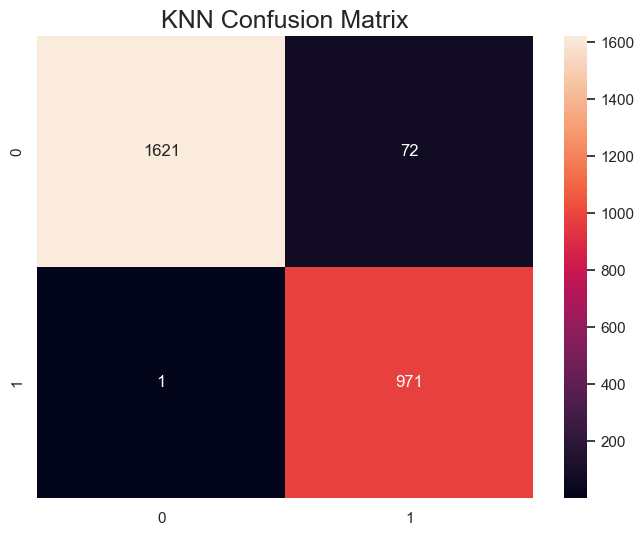

Accuracy for KNN on validation data: 97.26%
Error Rate for KNN on validation data: 2.74%
Precision for KNN on validation data: 93.10%
Recall/Sensitivity for KNN on validation data: 99.90%


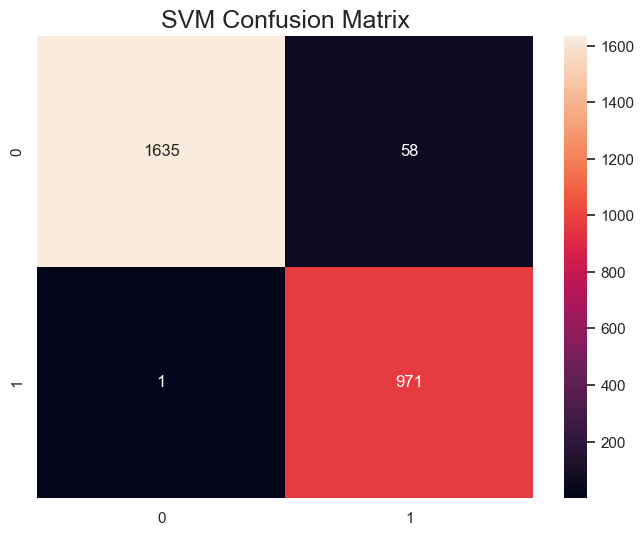

Accuracy for SVM on validation data: 97.79%
Error Rate for SVM on validation data: 2.21%
Precision for SVM on validation data: 94.36%
Recall/Sensitivity for SVM on validation data: 99.90%


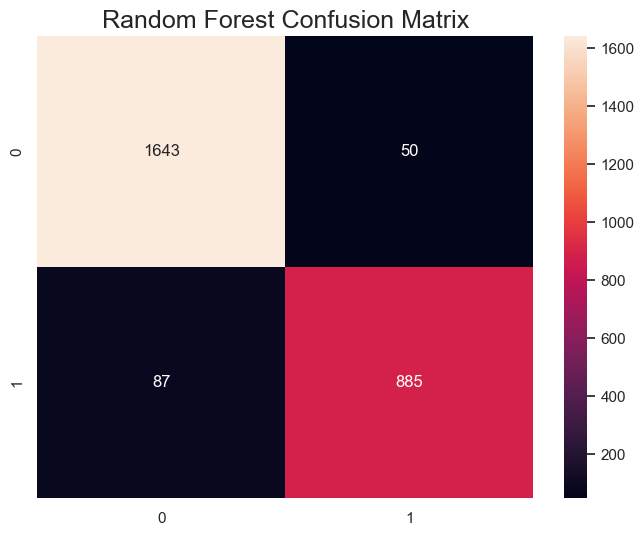

Accuracy for Random Forest on validation data: 94.86%
Error Rate for Random Forest on validation data: 5.14%
Precision for Random Forest on validation data: 94.65%
Recall/Sensitivity for Random Forest on validation data: 91.05%


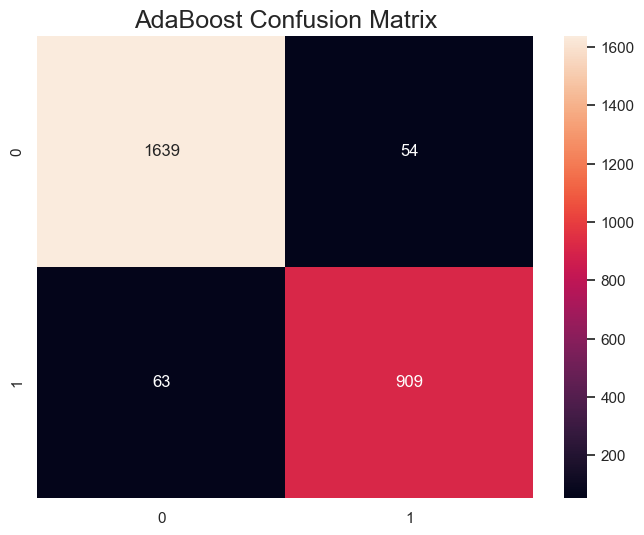

Accuracy for AdaBoost on validation data: 95.61%
Error Rate for AdaBoost on validation data: 4.39%
Precision for AdaBoost on validation data: 94.39%
Recall/Sensitivity for AdaBoost on validation data: 93.52%


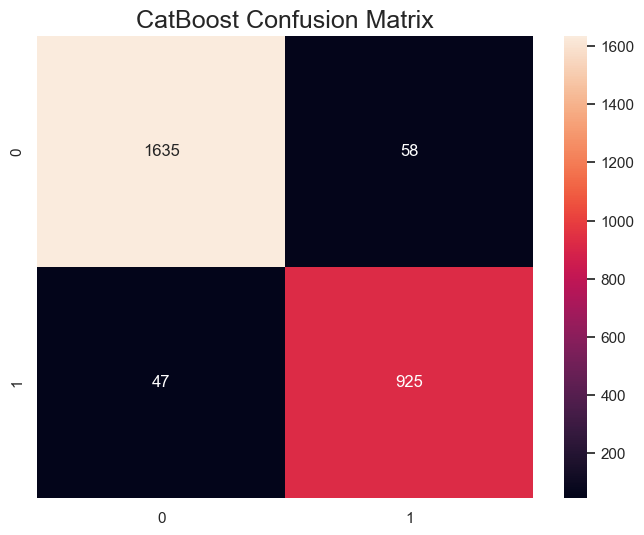

Accuracy for CatBoost on validation data: 96.06%
Error Rate for CatBoost on validation data: 3.94%
Precision for CatBoost on validation data: 94.10%
Recall/Sensitivity for CatBoost on validation data: 95.16%


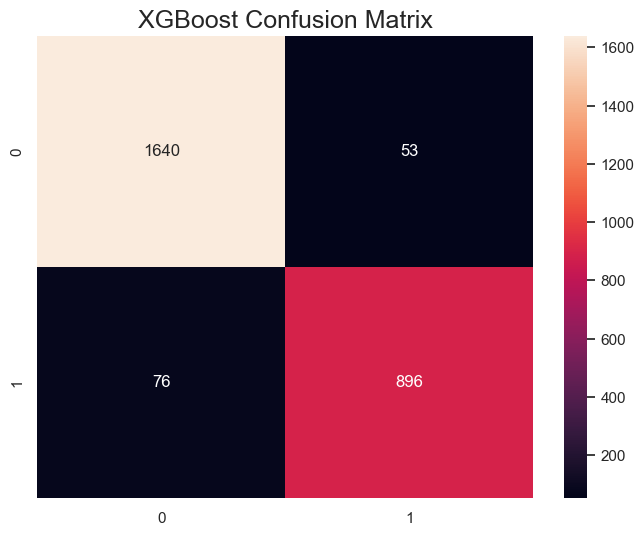

Accuracy for XGBoost on validation data: 95.16%
Error Rate for XGBoost on validation data: 4.84%
Precision for XGBoost on validation data: 94.42%
Recall/Sensitivity for XGBoost on validation data: 92.18%


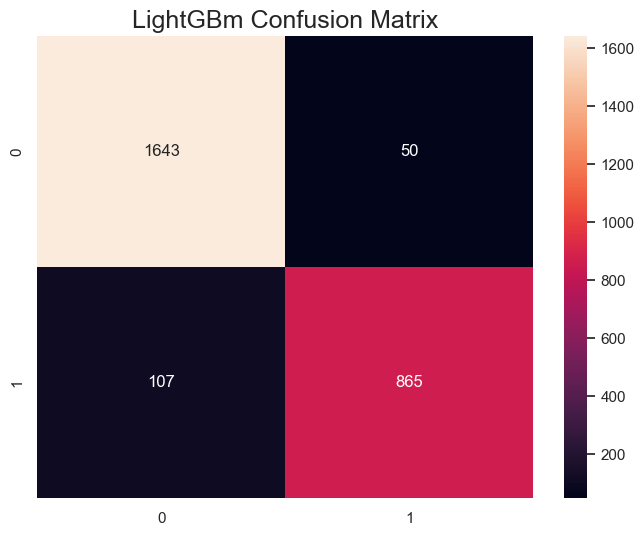

Accuracy for LightGBm on validation data: 94.11%
Error Rate for LightGBm on validation data: 5.89%
Precision for LightGBm on validation data: 94.54%
Recall/Sensitivity for LightGBm on validation data: 88.99%
84/84 [==============================] - 0s 1ms/step


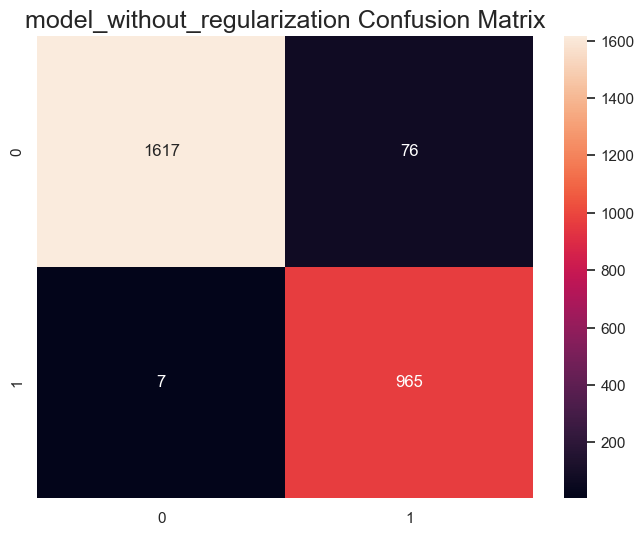

Accuracy for model_without_regularization on validation data: 96.89%
Error Rate for model_without_regularization on validation data: 3.11%
Precision for model_without_regularization on validation data: 92.70%
Recall/Sensitivity for model_without_regularization on validation data: 99.28%
84/84 [==============================] - 0s 1ms/step


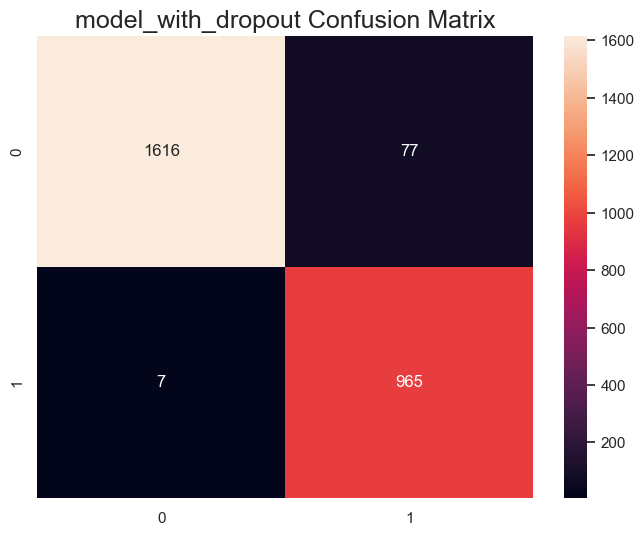

Accuracy for model_with_dropout on validation data: 96.85%
Error Rate for model_with_dropout on validation data: 3.15%
Precision for model_with_dropout on validation data: 92.61%
Recall/Sensitivity for model_with_dropout on validation data: 99.28%
84/84 [==============================] - 0s 1ms/step


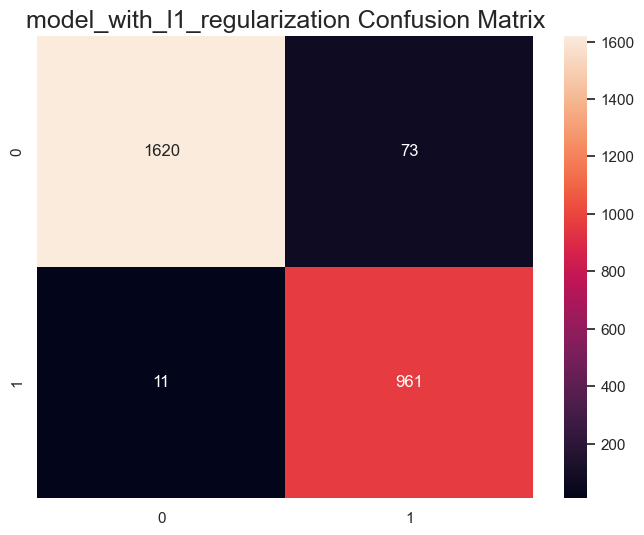

Accuracy for model_with_l1_regularization on validation data: 96.85%
Error Rate for model_with_l1_regularization on validation data: 3.15%
Precision for model_with_l1_regularization on validation data: 92.94%
Recall/Sensitivity for model_with_l1_regularization on validation data: 98.87%
84/84 [==============================] - 0s 1ms/step


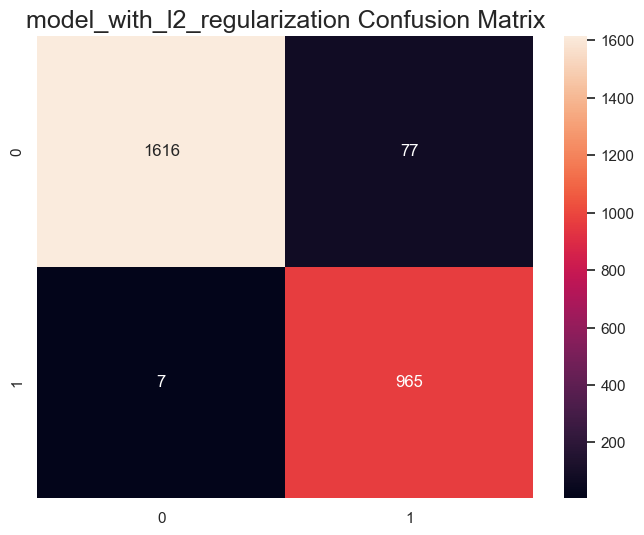

Accuracy for model_with_l2_regularization on validation data: 96.85%
Error Rate for model_with_l2_regularization on validation data: 3.15%
Precision for model_with_l2_regularization on validation data: 92.61%
Recall/Sensitivity for model_with_l2_regularization on validation data: 99.28%
84/84 [==============================] - 0s 1ms/step


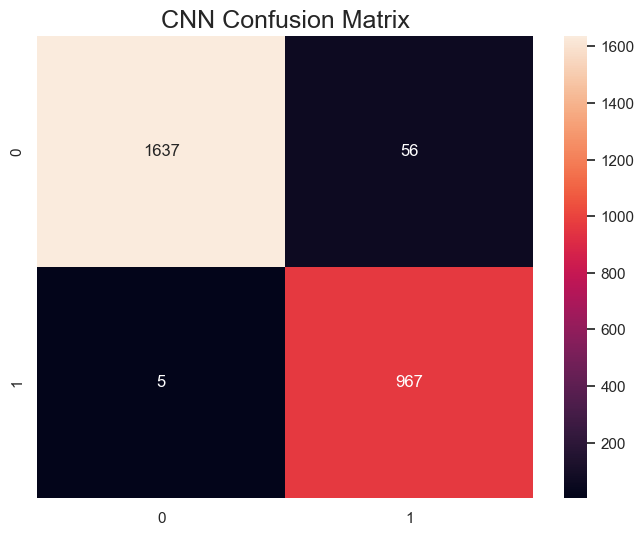

Accuracy for CNN on validation data: 97.71%
Error Rate for CNN on validation data: 2.29%
Precision for CNN on validation data: 94.53%
Recall/Sensitivity for CNN on validation data: 99.49%
84/84 [==============================] - 0s 2ms/step


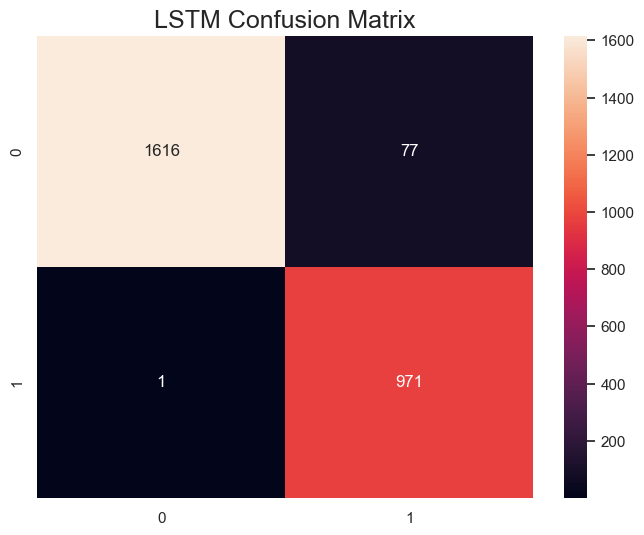

Accuracy for LSTM on validation data: 97.07%
Error Rate for LSTM on validation data: 2.93%
Precision for LSTM on validation data: 92.65%
Recall/Sensitivity for LSTM on validation data: 99.90%
84/84 [==============================] - 0s 2ms/step


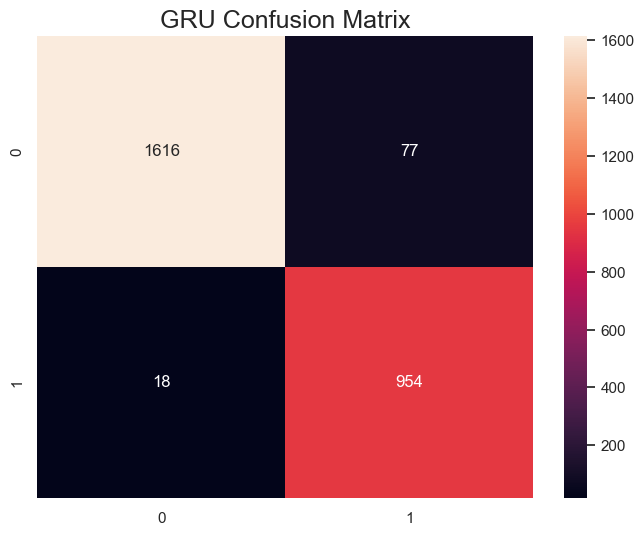

Accuracy for GRU on validation data: 96.44%
Error Rate for GRU on validation data: 3.56%
Precision for GRU on validation data: 92.53%
Recall/Sensitivity for GRU on validation data: 98.15%


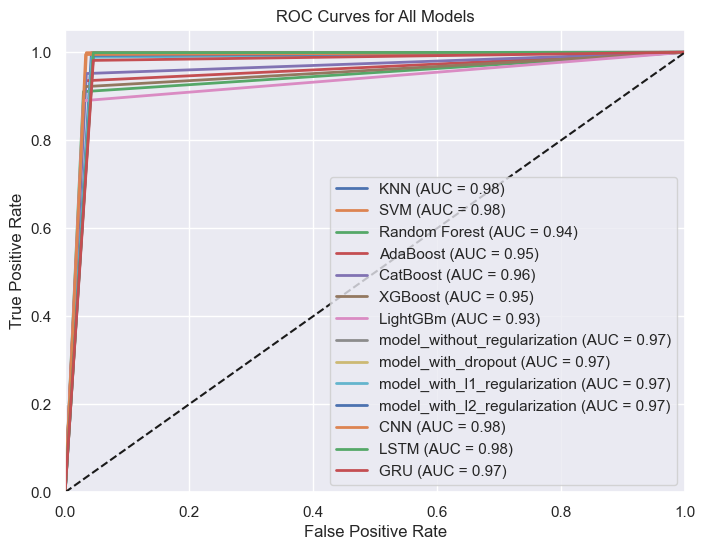

In [107]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Değerleri hesaplamak ve depolamak için boş listeler
accuracies = []
errors = []
precisions = []
recalls = []
sensitivities = []

all_fpr = []
all_tpr = []
all_auc = []

for model, model_name in zip(models, model_names):
    y_pred = model.predict(X_validation)
    threshold = 0.6
    y_pred = [1 if i >= threshold else 0 for i in y_pred]
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_validation, y_pred), annot=True, fmt="d")
    plt.title(f"{model_name} Confusion Matrix", fontdict={'fontsize':18})
    plt.show()
   
    accuracy = round(accuracy_score(y_validation, y_pred) * 100, 2)
    error = round(100 - accuracy, 2)
    precision = round(precision_score(y_validation, y_pred) * 100, 2)
    recall = round(recall_score(y_validation, y_pred) * 100, 2)
    sensitivity = round(recall, 2)  # Sensitivity is the same as recall
    
    accuracies.append(accuracy)
    errors.append(error)
    precisions.append(precision)
    recalls.append(recall)
    sensitivities.append(sensitivity)
        
    print(f"Accuracy for {model_name} on validation data: {accuracy:.2f}%")
    print(f"Error Rate for {model_name} on validation data: {error:.2f}%")
    print(f"Precision for {model_name} on validation data: {precision:.2f}%")
    print(f"Recall/Sensitivity for {model_name} on validation data: {sensitivity:.2f}%")

    fpr, tpr, _ = roc_curve(y_validation, y_pred)
    roc_auc = auc(fpr, tpr)
    
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_auc.append(roc_auc)

# Tüm ROC eğrilerini tek bir grafikte göster
plt.figure(figsize=(8, 6))
for fpr, tpr, model_name, roc_auc in zip(all_fpr, all_tpr, model_names, all_auc):
    plt.plot(fpr, tpr, lw=2, label=f"{model_name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc="lower right")
plt.show()


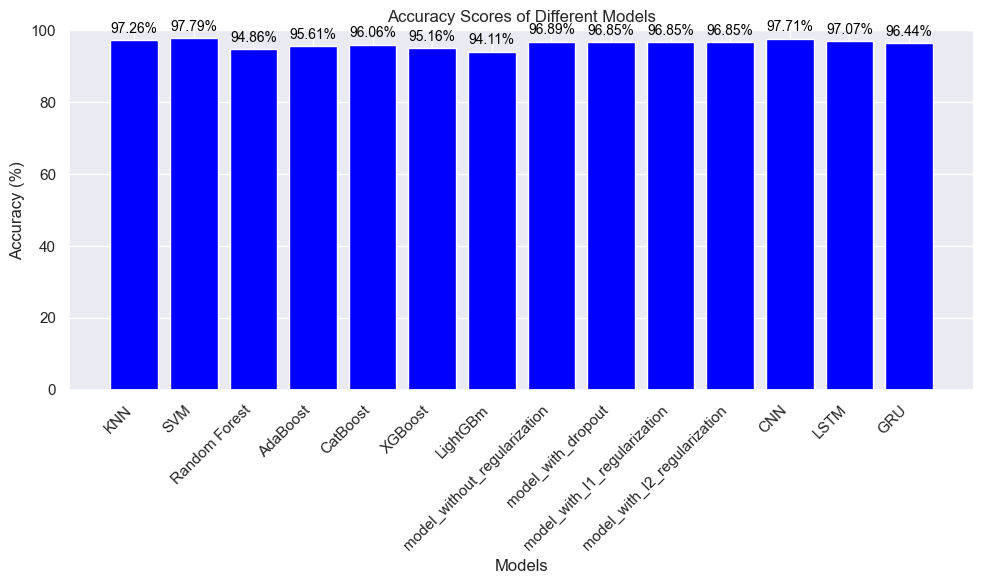

In [109]:
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies, color='blue')
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Scores of Different Models')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)

# Accuracy değerlerini çubukların üzerine yazdırma
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, acc + 2, f'{acc:.2f}%', ha='center', color='black', fontsize=10)

plt.tight_layout()
plt.show()

Validation verisi için en iyi sonucu SVM modeli vermiştir.

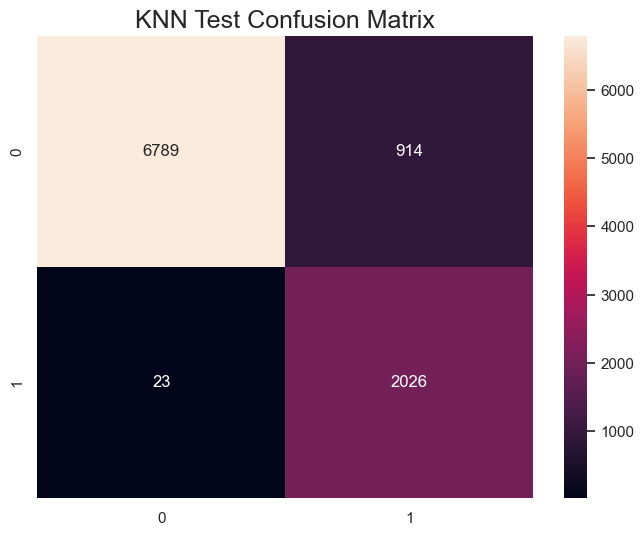

Test Accuracy for KNN: 90.39%
Test Error Rate for KNN: 9.61%
Test Precision for KNN: 68.91%
Test Recall/Sensitivity for KNN: 98.88%


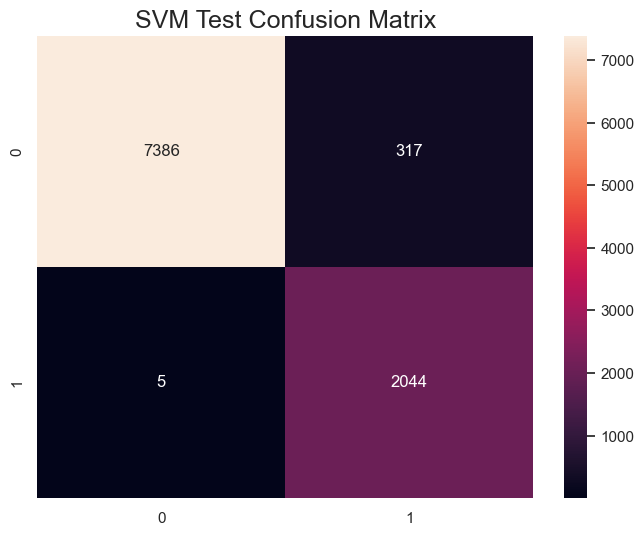

Test Accuracy for SVM: 96.70%
Test Error Rate for SVM: 3.30%
Test Precision for SVM: 86.57%
Test Recall/Sensitivity for SVM: 99.76%


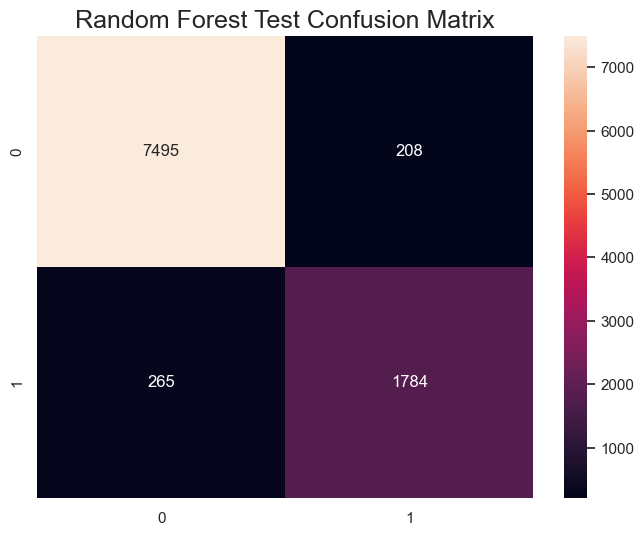

Test Accuracy for Random Forest: 95.15%
Test Error Rate for Random Forest: 4.85%
Test Precision for Random Forest: 89.56%
Test Recall/Sensitivity for Random Forest: 87.07%


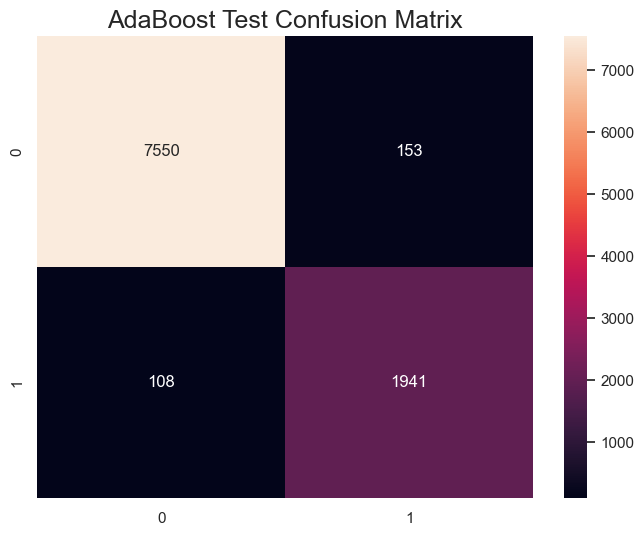

Test Accuracy for AdaBoost: 97.32%
Test Error Rate for AdaBoost: 2.68%
Test Precision for AdaBoost: 92.69%
Test Recall/Sensitivity for AdaBoost: 94.73%


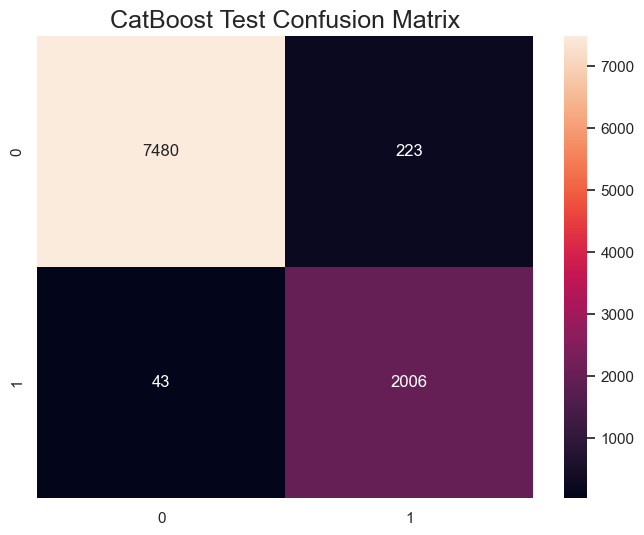

Test Accuracy for CatBoost: 97.27%
Test Error Rate for CatBoost: 2.73%
Test Precision for CatBoost: 90.00%
Test Recall/Sensitivity for CatBoost: 97.90%


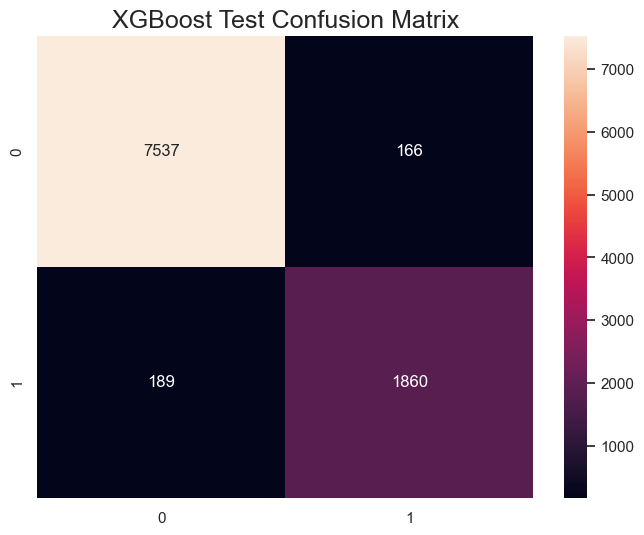

Test Accuracy for XGBoost: 96.36%
Test Error Rate for XGBoost: 3.64%
Test Precision for XGBoost: 91.81%
Test Recall/Sensitivity for XGBoost: 90.78%


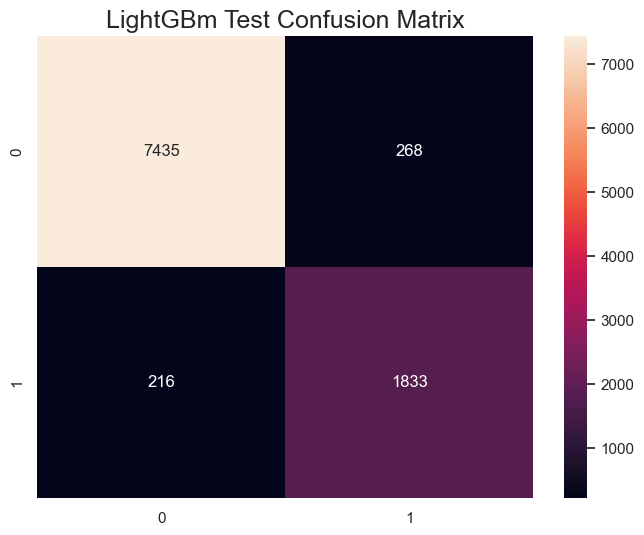

Test Accuracy for LightGBm: 95.04%
Test Error Rate for LightGBm: 4.96%
Test Precision for LightGBm: 87.24%
Test Recall/Sensitivity for LightGBm: 89.46%
305/305 [==============================] - 0s 1ms/step


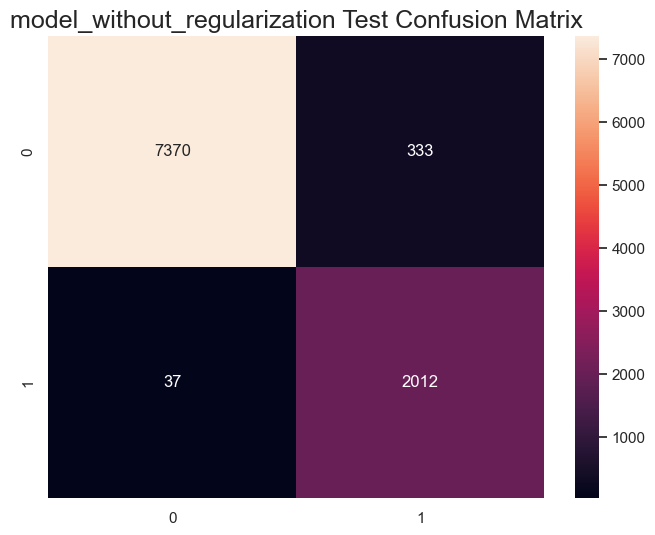

Test Accuracy for model_without_regularization: 96.21%
Test Error Rate for model_without_regularization: 3.79%
Test Precision for model_without_regularization: 85.80%
Test Recall/Sensitivity for model_without_regularization: 98.19%
305/305 [==============================] - 0s 1ms/step


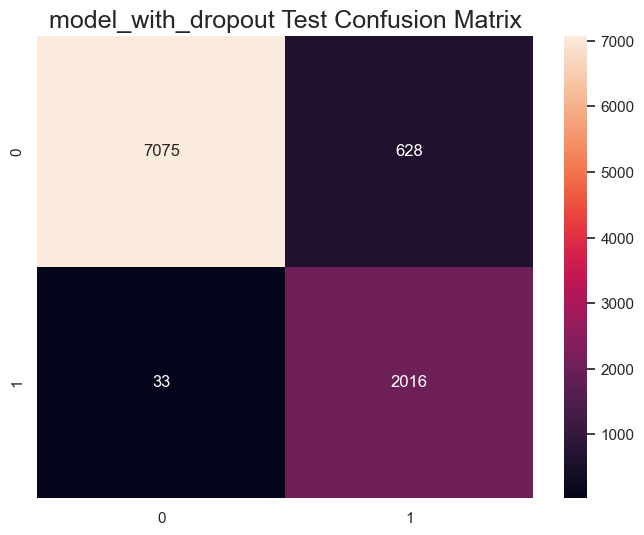

Test Accuracy for model_with_dropout: 93.22%
Test Error Rate for model_with_dropout: 6.78%
Test Precision for model_with_dropout: 76.25%
Test Recall/Sensitivity for model_with_dropout: 98.39%
305/305 [==============================] - 0s 1ms/step


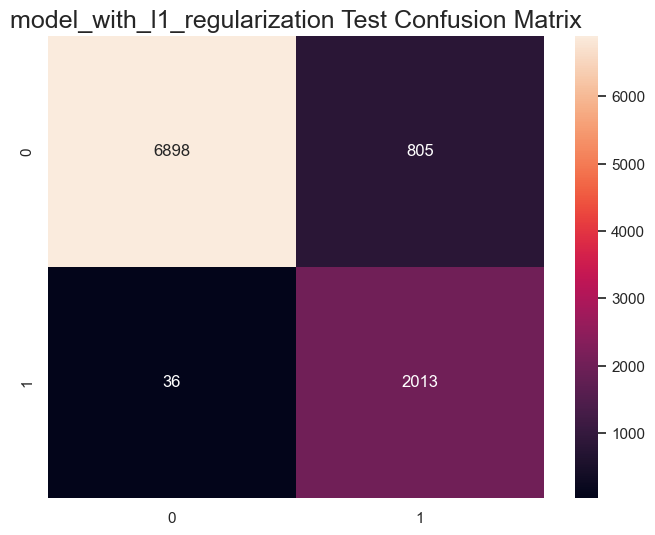

Test Accuracy for model_with_l1_regularization: 91.38%
Test Error Rate for model_with_l1_regularization: 8.62%
Test Precision for model_with_l1_regularization: 71.43%
Test Recall/Sensitivity for model_with_l1_regularization: 98.24%
305/305 [==============================] - 0s 1ms/step


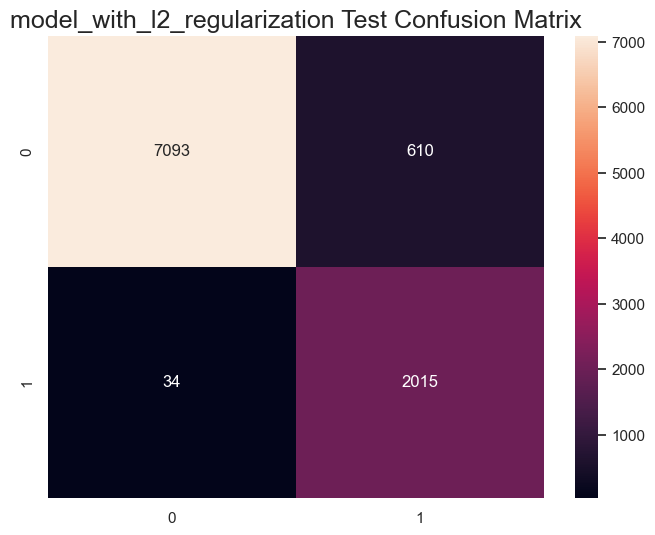

Test Accuracy for model_with_l2_regularization: 93.40%
Test Error Rate for model_with_l2_regularization: 6.60%
Test Precision for model_with_l2_regularization: 76.76%
Test Recall/Sensitivity for model_with_l2_regularization: 98.34%
305/305 [==============================] - 0s 2ms/step


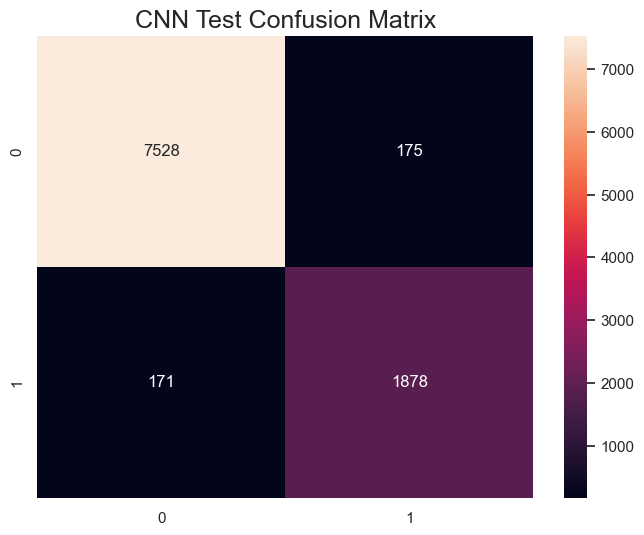

Test Accuracy for CNN: 96.45%
Test Error Rate for CNN: 3.55%
Test Precision for CNN: 91.48%
Test Recall/Sensitivity for CNN: 91.65%
305/305 [==============================] - 1s 2ms/step


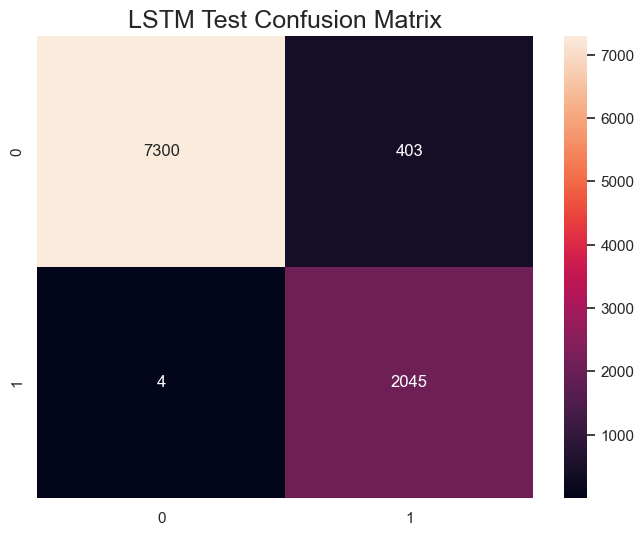

Test Accuracy for LSTM: 95.83%
Test Error Rate for LSTM: 4.17%
Test Precision for LSTM: 83.54%
Test Recall/Sensitivity for LSTM: 99.80%
305/305 [==============================] - 1s 2ms/step


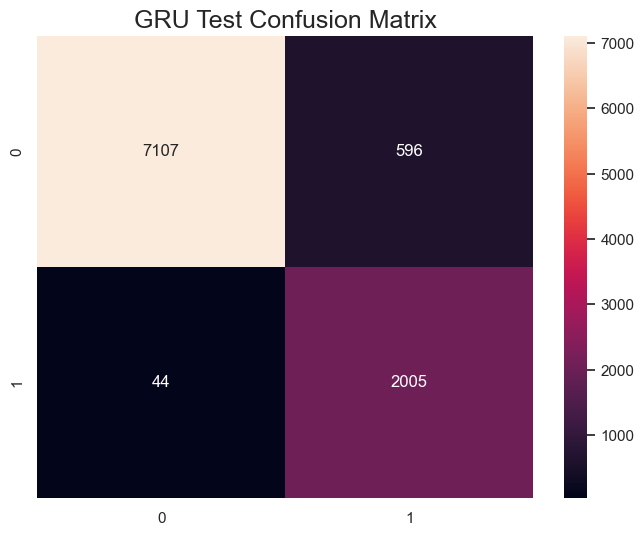

Test Accuracy for GRU: 93.44%
Test Error Rate for GRU: 6.56%
Test Precision for GRU: 77.09%
Test Recall/Sensitivity for GRU: 97.85%


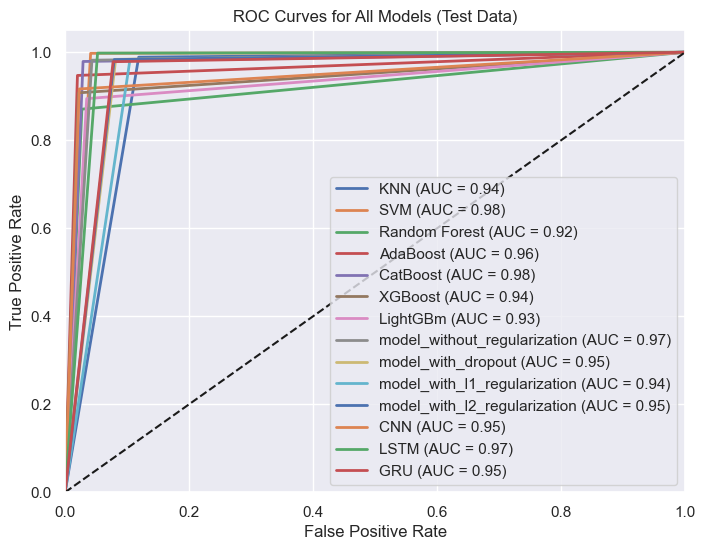

In [110]:
# Test verisi için boş listeler
test_accuracies = []
test_errors = []
test_precisions = []
test_recalls = []
test_sensitivities = []

test_all_fpr = []
test_all_tpr = []
test_all_auc = []

for model, model_name in zip(models, model_names):
    y_pred = model.predict(X_test)
    threshold = 0.6
    y_pred = [1 if i >= threshold else 0 for i in y_pred]
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")
    plt.title(f"{model_name} Test Confusion Matrix", fontdict={'fontsize':18})
    plt.show()
   
    test_accuracy = round(accuracy_score(y_test, y_pred) * 100, 2)
    test_error = round(100 - test_accuracy, 2)
    test_precision = round(precision_score(y_test, y_pred) * 100, 2)
    test_recall = round(recall_score(y_test, y_pred) * 100, 2)
    test_sensitivity = round(test_recall, 2)  # Sensitivity is the same as recall
    
    test_accuracies.append(test_accuracy)
    test_errors.append(test_error)
    test_precisions.append(test_precision)
    test_recalls.append(test_recall)
    test_sensitivities.append(test_sensitivity)
        
    print(f"Test Accuracy for {model_name}: {test_accuracy:.2f}%")
    print(f"Test Error Rate for {model_name}: {test_error:.2f}%")
    print(f"Test Precision for {model_name}: {test_precision:.2f}%")
    print(f"Test Recall/Sensitivity for {model_name}: {test_sensitivity:.2f}%")

    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    
    test_all_fpr.append(fpr)
    test_all_tpr.append(tpr)
    test_all_auc.append(roc_auc)

# Tüm test ROC eğrilerini tek bir grafikte göster
plt.figure(figsize=(8, 6))
for fpr, tpr, model_name, roc_auc in zip(test_all_fpr, test_all_tpr, model_names, test_all_auc):
    plt.plot(fpr, tpr, lw=2, label=f"{model_name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models (Test Data)')
plt.legend(loc="lower right")
plt.show()


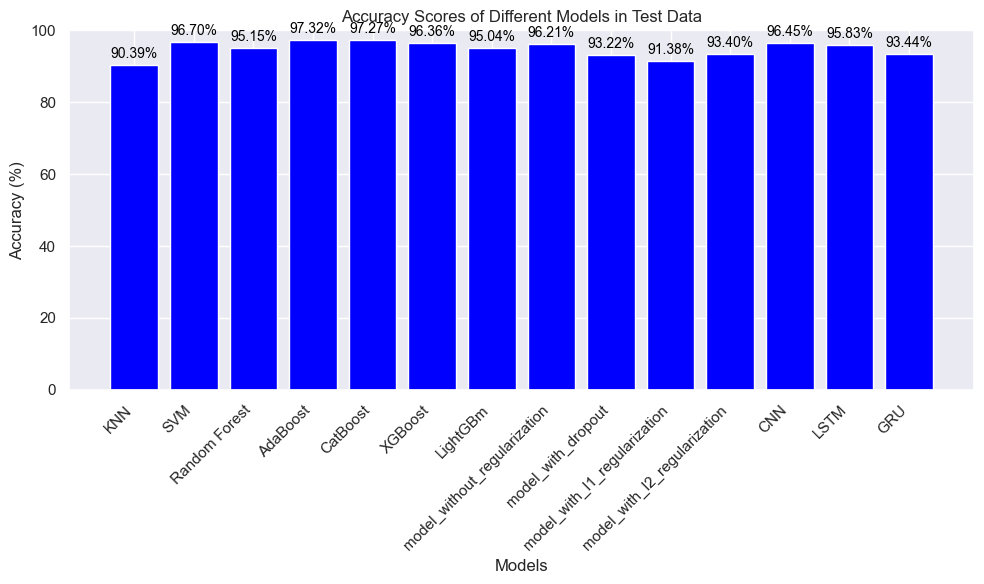

In [112]:
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, test_accuracies, color='blue')
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Scores of Different Models in Test Data')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)

# Accuracy değerlerini çubukların üzerine yazdırma
for bar, acc in zip(bars, test_accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, acc + 2, f'{acc:.2f}%', ha='center', color='black', fontsize=10)

plt.tight_layout()
plt.show()

En iyi sonucu SVM ve AdaBoost modeli vermiştir